# CAO Points - Author: Andrew Scott

The Central Applications Office (CAO) is the organisation responsible for processing applications for Irish Higher Education Institutions[<sup>1</sup>](#f1).<a id='a1'></a>. Each year they publish the points, which are a reflection of the grades earned during the Leaving Certificate examinations[<sup>2</sup>](#f2)<a id='a2'></a>, that were required to be offered a place for every course. This notebook uses Python to acquire and analyse the points required for courses that were published by the CAO for the years 2018-2021. This notebook will contain Python code and its outputs, as well as text that expands upon the code. Wherever code requires a reference, a link to the reference will be provided in the code comments. References in the text will be numbered and a reference section at the end of this notebook will provide further information about the source. 

## Table of Contents
* [**Functions**](#h1)
* [**Accessing and Importing Points Data**](#h2)
    * [**2021 Level 8 Points**](#h3)
    * [**2021 Level 7 and 6 Points**](#h4)
    * [**2021 Level 8, 7, and 6 Points Addendum**](#h5)
    * [**2021 2020 Level 8, 7, and 6 Points**](#h6)
    * [**2019 Level 8 Points**](#h7)
    * [**2019 Level 7 and 6 Points**](#h8)
    * [**2018 Level 8 Points**](#h9)
    * [**2018 Level 7 and 6 Points**](#h10)
* [**Concatenate and Join**](#h11)
    * [**Concatenate Level 8 Courses**](#h12)
    * [**Join Level 8 Points**](#h13)
    * [**Concatenate Level 7 and 6 Courses**](#h14)
    * [**Join Level 7 and 6 Points**](#h15)
* [**Analysis**](#h16)
    * [**Level 8 Analysis**](#h17)
    * [**Level 7 and 6 Analysis**](#h18)
    * [**Analysis - All Levels**](#h19)
* [**Conclusion**](#h20)
* [**References**](#h21)


In [1]:
# Packages used throughout this notebook

# For dataframes: https://pandas.pydata.org/
import pandas as pd

# Numerical arrays: https://numpy.org/
import numpy as np

# For HTTP requests: https://python-rq.org/
import requests as rq

# For regular expressions: https://docs.python.org/3/library/re.html
import re

# For accessing dates and times: https://docs.python.org/3/library/datetime.html
import datetime as dt

# Accessing and downloading using urls: https://docs.python.org/3/library/urllib.request.html
import urllib.request as urlrq

# For reading pdfs: https://tabula-py.readthedocs.io/en/latest/
import tabula

# Plotting: https://matplotlib.org/
import matplotlib.pyplot as plt

# Plotting: https://seaborn.pydata.org/
import seaborn as sns

# Change default sns theme: https://seaborn.pydata.org/generated/seaborn.set_theme.html
sns.set_theme()

Datetime is used to create a variable that will refer to a string stating the current time. This will be used throughout this notebook to save files with the current time in the filename, ensuring a unique file name each time.

In [2]:
# Access the current date and time: https://docs.python.org/3/library/datetime.html
now = dt.datetime.now()

# Formatting the current date and time as a string and saving it to a variable.
current_time = now.strftime('%Y%m%d_%H%M%S')

There are times where it is useful to display the entire dataframe - for example, to quickly view the dataframe for any obvious errors, which the code below allows. However, enabling this at all times makes the notebook slow and difficult to navigate, which is why it is now commented out so it won't run.

In [3]:
# Make dataframe scrollable: https://pandas.pydata.org/docs/reference/api/pandas.set_option.html
# pd.set_option("display.max_rows", None)

## Functions<a id='h1'></a>

Below are the functions that were created to be used with the CAO data in this notebook. These are snippets of codes that can be reused wherever appropriate to prevent retyping code that serves a similar purpose. However, the different formats that the CAO stores its data limits how often these functions can be reused. As such, functions that work on the data initially imported such as finding courses with unique symbols like a '#' or 'AQA' in the 2021 dataset were not used as often as originally anticipated, and instead, new code was written for each year. These functions will only work for the CAO data accessed via a webpage, and will not work with the data they provide via excel or pdf files. The purposes of each function will be elaborated on whenever they appear throughout this notebook.

Also, note that these functions will need to be edited to work with new data if years after 2021 or before 2018 are added for analysis in the future.

In [4]:
# A function that finds courses that required Test / Interview / Portfolio / Audition
# As indicated by the '#' character
def portfolio(df):
    # Find '#' in pointsR1 column
    df_portfolio1 = df[df['pointsR1'].str.match("#", na=False)]
    # find '#' in pointsR2 column
    df_portfolio2 = df[df['pointsR2'].str.match("#", na=False)]
    # Concat the dataframes together
    df_portfolio = pd.concat([df_portfolio1, df_portfolio2], ignore_index=True)
    # Remove duplicates
    df_portfolio = df_portfolio.drop_duplicates()
    return df_portfolio

In [5]:
# A function that finds courses where all on this points score were offered places
# As indicated by the '*' character
def random(df):
    # Find '*' in pointsR1 column
    df_random1 = df[df['pointsR1'].str[-1] == '*']
    # find '#' in pointsR2 column
    df_random2 = df[df['pointsR2'].str[-1] == '*']
    # Concat the dataframes together
    df_random = pd.concat([df_random1, df_random2], ignore_index=True)
    # Remove duplicates
    df_random = df_random.drop_duplicates()
    return df_random

In [6]:
# A function that finds courses where all qualified applicants earned places
# As indicated by AQA
def aqa(df):
    # Find 'AQA' in pointsR1 column
    df_aqa1 = df[df['pointsR1'].str.match("AQA", na=False)]
    # find 'AQA' in pointsR2 column
    df_aqa2 = df[df['pointsR2'].str.match("AQA", na=False)]
    # Concat the dataframes together
    df_aqa = pd.concat([df_aqa1, df_aqa2], ignore_index=True)
    # Remove duplicates
    df_aqa = df_aqa.drop_duplicates()
    return df_aqa

In [7]:
# A function that finds courses where there's new competition for available places
# As indicated by the 'v' character
def comp(df):
    # Find 'v' in pointsR1 column
    df_comp1 = df[df['pointsR1'].str[-1] == 'v']
    # find 'v' in pointsR2 column
    df_comp2 = df[df['pointsR2'].str[-1] == 'v']
    # Concat the dataframes together
    df_comp = pd.concat([df_comp1, df_comp2], ignore_index=True)
    # Remove duplicates
    df_comp = df_comp.drop_duplicates()
    return df_comp

In [8]:
# Function that finds the mean difference in points each year, then returns the mean of those means
def mean_diff(df):
    midm21 = pd.to_numeric(df['EOS Mid 2021'], errors='coerce').mean()
    # Code adapted from: 
    # https://stackoverflow.com/questions/55256184/python-how-to-get-a-columns-mean-if-there-is-string-value-too
    eosm21 = pd.to_numeric(df['EOS 2021'], errors='coerce').mean()
    diff21 = midm21 - eosm21
    print(diff21)
    midm20 = pd.to_numeric(df['EOS Mid 2020'], errors='coerce').mean() 
    eosm20 = pd.to_numeric(df['EOS 2020'], errors='coerce').mean()
    diff20 = midm20 - eosm20
    print(diff20)
    midm19 = pd.to_numeric(df['EOS Mid 2019'], errors='coerce').mean()
    eosm19 = pd.to_numeric(df['EOS 2019'], errors='coerce').mean()
    diff19 = midm19 - eosm19
    print(diff19)
    midm18 = pd.to_numeric(df['EOS Mid 2018'], errors='coerce').mean()
    eosm18 = pd.to_numeric(df['EOS 2018'], errors='coerce').mean()
    diff18 = midm18 - eosm18
    print(diff18)    
    diff = np.array([diff21, diff20, diff19, diff18])
    diff_mean = np.mean(diff)
    return diff_mean

In [9]:
# A function that will replace AQA values with an estimated points based on the 
# known mean difference between EOS and EOS Mid
def aqa_imputate(df, mean):
    # New columns that contain the Mid values minus the mean difference
    df['Diff 2021'] = df['EOS Mid 2021'] - mean
    df['Diff 2020'] = df['EOS Mid 2020'] - mean
    # Had to convert column to float due to error detecting a string
    df['Diff 2019'] = df['EOS Mid 2019'].astype('float') - mean
    df['Diff 2018'] = df['EOS Mid 2018'].astype('float') - mean
    # replace AQA with diff points values
    # Code adapted from: 
    # https://stackoverflow.com/questions/69965208/numpy-where-condition-when-met-must-modify-the-original-value-if-not-original-v
    df['EOS 2021']=df['EOS 2021'].mask(df['EOS 2021'].eq('AQA'),df['Diff 2021'])
    df['EOS 2020']=df['EOS 2020'].mask(df['EOS 2020'].eq('AQA'),df['Diff 2020'])
    df['EOS 2019']=df['EOS 2019'].mask(df['EOS 2019'].eq('AQA'),df['Diff 2019'])
    df['EOS 2018']=df['EOS 2018'].mask(df['EOS 2018'].eq('AQA'),df['Diff 2018'])
    return df.loc[:, 'Course Title':'EOS Mid 2018']

In [10]:
# A function that will replace +mat values with an estimated points based on the 
# known mean difference between EOS and EOS Mid
def mat_imputate(df, mean):
    # New columns that contain the Mid values minus the mean difference
    df['Diff 2021'] = df['EOS Mid 2021'] - mean
    df['Diff 2020'] = df['EOS Mid 2020'] - mean
    # Had to convert column to float due to error detecting a string
    df['Diff 2019'] = df['EOS Mid 2019'].astype('float') - mean
    df['Diff 2018'] = df['EOS Mid 2018'].astype('float') - mean
    # replace +mat with diff points values
    # Code adapted from: 
    # https://stackoverflow.com/questions/69965208/numpy-where-condition-when-met-must-modify-the-original-value-if-not-original-v
    df['EOS 2021']=df['EOS 2021'].mask(df['EOS 2021'].eq(' +mat'),df['Diff 2021'])
    df['EOS 2020']=df['EOS 2020'].mask(df['EOS 2020'].eq(' +mat'),df['Diff 2020'])
    df['EOS 2019']=df['EOS 2019'].mask(df['EOS 2019'].eq(' +mat'),df['Diff 2019'])
    df['EOS 2018']=df['EOS 2018'].mask(df['EOS 2018'].eq(' +mat'),df['Diff 2018'])
    return df.loc[:, 'Course Title':'EOS Mid 2018']

In [11]:
# Function that plots histograms of each year's Mid points
# Code adapted from: https://www.python-graph-gallery.com/25-histogram-with-several-variables-seaborn

def hist_by_year(df):
    fig, axs = plt.subplots(2, 2, figsize=(9, 9))

    sns.histplot(data=df, x="EOS Mid 2021", kde=True, color="skyblue", ax=axs[0, 0])
    sns.histplot(data=df, x="EOS Mid 2020", kde=True, color="purple", ax=axs[0, 1])
    sns.histplot(data=df, x="EOS Mid 2019", kde=True, color="gold", ax=axs[1, 0])
    sns.histplot(data=df, x="EOS Mid 2018", kde=True, color="green", ax=axs[1, 1])
    fig.suptitle("Distribution of CAO Points Received")
    plt.savefig('cao-analysis\level-8\hist-mid-l8.png')
    return fig

In [12]:
# Function that returns a barplot of the provided course code and df
# Code for headed adapted from:
# https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot
# It is recommended that this function is only used with the following dataframes: 
# allcourses_l8_eos (For Level 8 courses)
# allcourses_l76_eos (For Level 7 and 6 courses)

def course_bar(code, df):
    df1 = df[['EOS 2021', 'EOS 2020', 'EOS 2019', 'EOS 2018',
          'EOS Mid 2021', 'EOS Mid 2020', 'EOS Mid 2019', 'EOS Mid 2018']]
    df1 = df1.transpose()
    plot = sns.catplot(x=code, y=df1.index, data=df1, kind='bar')
    plot.fig.subplots_adjust(top=0.9)
    plot.fig.suptitle("Points Required for Course")
    
    
    # Not an ideal solution since a new df or additions to existing dfs
    # this code should suffice for now with the dfs we currently have
    if df['Course Title'].count() >= 1000:
        plt.savefig(r'cao-analysis\level-8\bar-' + code + '.png')
    else:
        plt.savefig(r'cao-analysis\level-7-and-6\bar-' + code + '.png')
    return plot

Below, we will look at the CAO data from most recent to oldest, starting with 2021. Since the CAO also divides their data into Level 8 points and courses and Levels 7 and 6 points and courses, this notebook will follow this structure by first looking at Level 8 for a year followed by Levels 7 and 6.

--------

## Accessing and Importing Points Data<a id='h2'></a>

### 2021 Level 8 Points<a id='h3'></a>

The CAO list the points for 2021 on a webpage[<sup>3</sup>](#f3)<a id='a3'></a>, so the first step is to send a request to access the webpage in Python using the requests package. 

In [13]:
# Make HTTP request for the page containing CAO points data
resp2021_l8 = rq.get('http://www2.cao.ie/points/l8.php')

We can check if the request is successful, which is indicated by a '<Response [200]>' output.

In [14]:
# Check if the request is successful
resp2021_l8

<Response [200]>

There was an issue with the encoding on the webpage, with the following error being returned - "'charmap' codec can't encode character '\x96' in position 25767: character maps to \<undefined>". This can be fixed by changing the original encoding, 'iso-8859-1', to 'cp1252', which will recognise the '\x96' character[<sup>4</sup>](#f4)<a id='a4'></a>.

In [15]:
# The server uses the wrong encoding.
original_encoding = resp2021_l8.encoding

# Change to cp1252, which recognises the '\x96' character.
resp2021_l8.encoding = 'cp1252'

The next step is to create a file path for the original data and save the HTML file of the original webpage. This is to preserve the state of the webpage at the time the page was accessed, so if the CAO changes or removes the webpage, we have a backup of the webpage as it was at the time of the analysis that we can refer to instead. This can be done using the write() method[<sup>5</sup>](#f5)<a id='a5'></a>.

In [16]:
# Create a file path for the original data.
path2021_l8_html = 'cao-data/2021-points/2021-level-8-points/cao2021_level8_' + current_time + '.html'

In [17]:
# Save the original html file.
with open(path2021_l8_html, 'w') as f:
    f.write(resp2021_l8.text)

The webpage of 2021 data contains information not suitable for a Pandas dataframe, such as the listing of institution names and various hyperlinks throughout the page. For a Pandas dataframe, we would like the data to contain the line which contain the points information and be formatted in a manner such that everything can be neatly written to rows and columns. Fortunately, the CAO webpage has the information we need in a format we can access using regular expressions. We can take advantage of the fact all the lines we require begin with a course code, which starts with two letters that indicate the institution offering the course, followed by three digits, ensuring each course has a unique five-character identifier. We can use a regular expression to access only the lines that start in this manner. The regular expression below finds two letters from A-Z followed by three numbers from 0-9, and returns everything else from that line with a wildcard * character.

In [18]:
# Code adapted from: https://github.com/ianmcloughlin/cao-points/blob/main/cao-points-analysis.ipynb
# Using regular expression to extract the lines of data we want.
re_course = re.compile(r'([A-Z]{2}[0-9]{3})(.*)')

While we can use the regular expression to access the lines we need, they still need further processing to make everything suitable for Pandas. The code below first writes a header which we can use as names for our dataframe columns. The code then loops through every line extracted by the regular expression and slices it so that each element of that line can be added to a separate column, stripping unnecessary spaces and ensuring each element can be sorted into an appropriate column by separating each element with a comma, such that we will be left with the five-character course code, course title, and points ready to be added to the correct dataframe columns. This all creates a comma separated value(CSV) file that can be used to load the data into a Pandas dataframe.

In [19]:
# Code adapted from: https://github.com/ianmcloughlin/cao-points/blob/main/cao-points-analysis.ipynb


# The file path for the csv file.
path2021_l8 = 'cao-data/2021-points/2021-level-8-points/cao2021_level8_csv_' + current_time + '.csv'

# Keep track of how many courses we process.
no_lines = 0

# Open the csv file for writing.
with open(path2021_l8, 'w') as f:
    # Write a header row.
    f.write(','.join(['code', 'title', 'pointsR1', 'pointsR2']) + '\n')
    # Loop through lines of the response.
    for line in resp2021_l8.iter_lines():
        # Decode the line, using the wrong encoding!
        dline = line.decode('cp1252')
        # Match only the lines representing courses.
        if re_course.fullmatch(dline):
            # Add one to the lines counter.
            no_lines = no_lines + 1
            # The course code.
            course_code = dline[:5]
            # The course title.
            course_title = dline[7:57].strip()
            # Round one points.
            course_points = re.split(' +', dline[60:])
            if len(course_points) != 2:
                course_points = course_points[:2]
            # Join the fields using a comma.
            linesplit = [course_code, course_title, course_points[0], course_points[1]]
            # Rejoin the substrings with commas in between.
            f.write(','.join(linesplit) + '\n')

# Print the total number of processed lines.
print(f"Total number of lines is {no_lines}.")

Total number of lines is 949.


We can now load the data into a dataframe using the package Pandas, which will allow us to access and analyse the data in a Python-friendly format. 

In [20]:
# Load the 2021 level 8 data to a Pandas dataframe
df2021_l8 = pd.read_csv(path2021_l8, encoding='cp1252')

In [21]:
# View the dataframe
df2021_l8

,code,title,pointsR1,pointsR2
0,AL801,Software Design for Virtual Reality and Gaming,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,321,NaN
4,AL810,Quantity Surveying,328,NaN
...,...,...,...,...
944,WD211,Creative Computing,270,NaN
945,WD212,Recreation and Sport Management,262,NaN
946,WD230,Mechanical and Manufacturing Engineering,230,230
947,WD231,Early Childhood Care and Education,266,NaN


The CAO uses symbols and letters alongside points to point to some special features about that course. A '#' symbol indicates that the course requires additional criteria alongside points, such as a portfolio, test, interview, or audition. A '*' symbol indicates that not everyone that received that points total was offered a place, so a place on the course was offered randomly to select people with that points total. AQA stands for 'All Qualified Applicants', which means that there was no cut off points total to be offered a place on that course and everyone who applied was accepted. To perform analysis on the points columns, anything that isn't a digit will need to be removed. With symbols/letters alongside numbers, Pandas will treat the contents of the columns as strings and it will not be able to perform any mathematical or statistical calculations on the columns. To do this the columns need to contain numbers only. However, the symbols do provide useful information worth preserving. For that reason, new dataframes will be created to store all the courses that were marked by the CAO with additional symbols. These are found in the 2021 data using prewritten functions that first check the first points column for a particular symbol, does the same for the second points column, and then concatenates and joins the findings into a dataframe. As noted previously, these functions only work with the 2021 data as in other years the CAO marks these courses differently, either by having a new column for these symbols or by only including the symbols in one column rather than two.

In [22]:
# Extracting all Portfolio/Test/Interview/Audition courses 
df2021_l8_portfolio = portfolio(df2021_l8)

In [23]:
# View the dataframe
df2021_l8_portfolio

,code,title,pointsR1,pointsR2
0,AL861,Animation and Illustration (portfolio),#575,NaN
1,AL863,Graphic and Digital Design (portfolio),#747,NaN
2,CW038,Art (portfolio),#700,NaN
3,CW858,Sports Management and Coaching (options portf...,#700,NaN
4,CR121,Music at CIT Cork School of Music,#904,#904
...,...,...,...,...
78,SG244,Fine Art,#501,NaN
79,TL801,Animation Visual Effects and Motion Design (L...,#718,NaN
80,WD027,Music,#321,NaN
96,MH802,Community and Youth Work (part-time in service),NaN,#


In [24]:
# Extracting courses where not everyone with those points were offered places
df2021_l8_random = random(df2021_l8)

In [25]:
# View the dataframe
df2021_l8_random

,code,title,pointsR1,pointsR2
0,AL830,General Nursing,451*,444
1,AL832,Mental Health Nursing,440*,431
2,AL870,Applied Psychology,484*,467*
3,CR320,Biomedical Science - Offered jointly by CIT an...,590*,NaN
4,CR930,Home Economics and Business,518*,NaN
...,...,...,...,...
118,DN600,Law (options),576,567*
119,DN660,Commerce International (options),555,554*
120,DN710,Economics,534,532*
123,LM090,Physical Education with concurrent Teacher Edu...,552,544*


In [26]:
# Extracting courses where all qualified applicants earned places
df2021_l8_aqa = aqa(df2021_l8)

In [27]:
# View the dataframe
df2021_l8_aqa

,code,title,pointsR1,pointsR2
0,MH801,Early Childhood - Teaching and Learning (part-...,AQA,AQA


To make it easier to join the data from various years, the columns were renamed to match those of later years. It was decided to rename the 2021 columns rather than the later years as these names are more commonly used in later years, making it easier to change 2021 rather than every other year. 

In [28]:
# Rename columns of original df to match later dataframes
df2021_l8.rename(columns={'code': 'Course Code', 'title': 'INSTITUTION and COURSE'}, inplace=True)

In [29]:
# View the dataframe
df2021_l8

,Course Code,INSTITUTION and COURSE,pointsR1,pointsR2
0,AL801,Software Design for Virtual Reality and Gaming,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,321,NaN
4,AL810,Quantity Surveying,328,NaN
...,...,...,...,...
944,WD211,Creative Computing,270,NaN
945,WD212,Recreation and Sport Management,262,NaN
946,WD230,Mechanical and Manufacturing Engineering,230,230
947,WD231,Early Childhood Care and Education,266,NaN


We now almost have the data usefully formatted and loaded for further analysis. There will need to be some more processing needed to remove symbols from points columns and to join the data from every year, which will be done after we have loaded the data for every year from 2018-2021.

In [30]:
# Save Pandas dataframe to disk.
df2021_l8.to_csv(path2021_l8)

While smaller dataframes have been created containing information such as courses where all qualified applicants were offered a place on the course, these will not be saved to disk. Instead, only the main dataframes acquired for each year and the later dataframes made up of concatenating and joining the various year's data will be saved and backed up each time to avoid the cao-data folder becoming too dense with various folders and files. Since the main dataframes still contain the symbols added by the CAO, that information is still backed up and can be reacquired from the saved dataframe if needs be.

### 2021 Level 7 and 6 Points<a id='h4'></a>

The 2021 points for Level 7 and 6 courses are listed on a separate webpage on the CAO website[<sup>6</sup>](#f6)<a id='a6'></a>, and will be acquired by repurposing much of the strategies and code used when acquiring the Level 8 points data, just changing the URL and variable names to reflect that this section deals with the 2021 Level 7 and 6 data. For this reason, there will be less text explaining the code in this section, except where there are notable differences. As mentioned previously, since the CAO provide points for Level 7 and 6 courses together, they will be combined in the analysis. 

In [31]:
# Make http request for the page containing CAO points data
resp2021_l76 = rq.get('http://www2.cao.ie/points/l76.php')

In [32]:
# Check if request is successful, indicated by '<Response [200]>' output
resp2021_l76

<Response [200]>

In [33]:
# Create a file path for the original data.
path2021_l76_html = 'cao-data/2021-points/2021-level-7-and-6-points/cao2021_level7_6_' + current_time + '.html'

In [34]:
# Save the original html file.
with open(path2021_l76_html, 'w') as f:
    f.write(resp2021_l76.text)

In [35]:
# Code adapted from: https://github.com/ianmcloughlin/cao-points/blob/main/cao-points-analysis.ipynb
# The file path for the csv file.
path2021_l76 = 'cao-data/2021-points/2021-level-7-and-6-points/cao2021_level7_6_csv_' + current_time + '.csv'

# Keep track of how many courses we process.
no_lines = 0

# Open the csv file for writing.
with open(path2021_l76, 'w') as f:
    # Write a header row.
    f.write(','.join(['code', 'title', 'pointsR1', 'pointsR2']) + '\n')
    # Loop through lines of the response.
    for line in resp2021_l76.iter_lines():
        # Decode the line, using the wrong encoding!
        dline = line.decode('cp1252')
        # Match only the lines representing courses.
        if re_course.fullmatch(dline):
            # Add one to the lines counter.
            no_lines = no_lines + 1
            # The course code.
            course_code = dline[:5]
            # The course title.
            course_title = dline[7:57].strip()
            # Round one points.
            course_points = re.split(' +', dline[60:])
            if len(course_points) != 2:
                course_points = course_points[:2]
            # Join the fields using a comma.
            linesplit = [course_code, course_title, course_points[0], course_points[1]]
            # Rejoin the substrings with commas in between.
            f.write(','.join(linesplit) + '\n')

# Print the total number of processed lines.
print(f"Total number of lines is {no_lines}.")

Total number of lines is 416.


In [36]:
# Load the 2021 level 7 and level 6 data to a Pandas dataframe
df2021_l76 = pd.read_csv(path2021_l76, encoding='cp1252')

In [37]:
# View the dataframe
df2021_l76

,code,title,pointsR1,pointsR2
0,AL605,Music and Instrument Technology,211,NaN
1,AL630,Pharmacy Technician,308,NaN
2,AL631,Dental Nursing,311,NaN
3,AL632,Applied Science,297,NaN
4,AL650,Business,AQA,AQA
...,...,...,...,...
411,WD188,Applied Health Care,220,NaN
412,WD205,Molecular Biology with Biopharmaceutical Science,AQA,262v
413,WD206,Electronic Engineering,180,NaN
414,WD207,Mechanical Engineering,172,NaN


In [38]:
# Extracting all Portfolio/Test/Interview/Audition courses 
df2021_l76_portfolio = portfolio(df2021_l76)

In [39]:
# View the dataframe
df2021_l76_portfolio

,code,title,pointsR1,pointsR2
0,AL763,Graphic Design (portfolio),#642,NaN
1,CW057,Art (portfolio),#700,NaN
2,CW807,Sport Coaching and Business Management - GAA (...,#700,NaN
3,CW817,Sport Coaching and Business Management - Rugby...,#700,NaN
4,CW827,Sport Coaching and Business Management - Socce...,#700,NaN
5,TU655,Computing (Networking Technologies) Learn and ...,#502,NaN
6,TU722,Process Instrumentation and Automation Learn a...,#346,#346
7,TU795,Visual Merchandising and Display,#618,NaN
8,TR802,Dental Hygiene,#577,#565
9,TR803,Dental Technology,#543,#498*


In [40]:
# Extracting courses where not everyone with those points were offered places
df2021_l76_random = random(df2021_l76)

In [41]:
# View the dataframe
df2021_l76_random

,code,title,pointsR1,pointsR2
0,LY847,Veterinary Nursing,389*,NaN
1,TR803,Dental Technology,#543,#498*


In [42]:
# Extracting courses where all qualified applicants earned places
df2021_l76_aqa = aqa(df2021_l76)

In [43]:
# View the dataframe
df2021_l76_aqa

,code,title,pointsR1,pointsR2
0,AL650,Business,AQA,AQA
1,AL660,Culinary Arts,AQA,AQA
2,AL661,Bar Supervision,AQA,NaN
3,AL663,Business (Sport and Recreation),AQA,AQA
4,AL761,Hotel and Leisure Management,AQA,AQA
5,TU772,Business (options),AQA,250v
6,TU792,Community and Youth Development,AQA,242v
7,WD003,Business,AQA,AQA
8,WD013,Legal Studies,AQA,206v
9,WD019,Recreation and Sport Management,AQA,AQA


There's an additional symbol in the Level 7 and 6 data, where the letter 'v' is added to the points totals to indicate that there's new competition for available places in that course. As before, these courses will be added to a new dataframe as the letter 'v' will need to be stripped before any analysis can be done. 

In [44]:
# Extracting courses where there's new competition for available places
df2021_l76_comp = comp(df2021_l76)

In [45]:
# View the dataframe
df2021_l76_comp

,code,title,pointsR1,pointsR2
0,TU708,Engineering (Common Entry with Award options),117,263v
1,TU772,Business (options),AQA,250v
2,TU792,Community and Youth Development,AQA,242v
3,WD013,Legal Studies,AQA,206v
4,WD177,Science (Mol. Biology with Biopharm. Food Science,205,455v
5,WD205,Molecular Biology with Biopharmaceutical Science,AQA,262v


In [46]:
# Rename columns of the original df to match later dataframes
df2021_l76.rename(columns={'code': 'Course Code', 'title': 'INSTITUTION and COURSE'}, inplace=True)

In [47]:
# View the dataframe
df2021_l76

,Course Code,INSTITUTION and COURSE,pointsR1,pointsR2
0,AL605,Music and Instrument Technology,211,NaN
1,AL630,Pharmacy Technician,308,NaN
2,AL631,Dental Nursing,311,NaN
3,AL632,Applied Science,297,NaN
4,AL650,Business,AQA,AQA
...,...,...,...,...
411,WD188,Applied Health Care,220,NaN
412,WD205,Molecular Biology with Biopharmaceutical Science,AQA,262v
413,WD206,Electronic Engineering,180,NaN
414,WD207,Mechanical Engineering,172,NaN


In [48]:
# Save Pandas dataframe to disk.
df2021_l76.to_csv(path2021_l76)

### 2021 Level 8, 7, and 6 Points Addendum<a id='h5'></a>

After the start of this project, the CAO website has released an excel file containing the points for all levels, as well as additional 2021 points information[<sup>7</sup>](#f7)<a id='a7'></a>. As of 13th of December 2021, they no longer link to the webpages with the points data used with earlier code, instead linking to the new excel file. The website used previously still appears to be live, and the code above will remain in the hopes they do not remove this link. It would be prudent to also load the excel file, however, not least because it contains additional points information such as EOS and Mid points values, which is also the points information given in years before 2020. Since the years 2019 and beyond do not include rounds points information, including the EOS and Mid values in the analysis will allow for a more valid comparison between the points values for all years.

As previously, the URL will be accessed to load it using Python, but there will be some differences since we are working with an excel file rather than a webpage. The file is requested and saved using urllib.request's urlretrieve() method and saved to backup the file.

In [49]:
# The points for levels 8, 7, and 6 were included in one spreadsheet on the CAO website
url2021_xlsx = 'http://www2.cao.ie/points/CAOPointsCharts2021.xlsx'

In [50]:
# Create a file path for the original data.
path2021_xlsx = 'cao-data/2021-points/2021-all-levels-points/cao2021_' + current_time + '.xlsx'

In [51]:
# Retrieve the excel file and save it 
urlrq.urlretrieve(url2021_xlsx, path2021_xlsx)

('cao-data/2021-points/2021-all-levels-points/cao2021_20220102_181417.xlsx',
 <http.client.HTTPMessage at 0x23793279280>)

Since an excel spreadsheet is much more similar to a Pandas dataframe than the earlier 2021 webpage was, we should be able to load the excel data straight to a dataframe using the pd.read_excel() method[<sup>8</sup>](#f8)<a id='a8'></a>. The opening 11 rows contain information we do not need, such as legends for symbols used, so we can specify that Pandas should skip these rows. 

The error 'XLRDError: Excel xlsx file; not supported' was returned when originally attempting to read the excel file to Pandas. The solution was to change the engine in an argument to 'openpyxl'[<sup>9</sup>](#f9)<a id='a9'></a>.

In [52]:
# Load the 2021 data to a Pandas dataframe
df2021_xlsx = pd.read_excel(url2021_xlsx, skiprows=11,  engine='openpyxl')

In [53]:
# View the dataframe
df2021_xlsx

,CATEGORY (ISCED Description),Course Title,Course Code,R1 Points,R1 Random,R2 Points,R2 Random,EOS Points,EOS Random,EOS Midpoints,Course Level,HEI,Test/Interview,AVP,v
0,Engineering and engineering trades,Music and Instrument Technology,AL605,211,NaN,NaN,NaN,211,NaN,319,6,Athlone Institute of Technology,NaN,NaN,NaN
1,Health,Pharmacy Technician,AL630,308,NaN,NaN,NaN,308,NaN,409,6,Athlone Institute of Technology,NaN,NaN,NaN
2,Health,Dental Nursing,AL631,311,NaN,NaN,NaN,311,NaN,400,6,Athlone Institute of Technology,NaN,NaN,NaN
3,Biological and related sciences,Applied Science,AL632,297,NaN,NaN,NaN,297,NaN,454,6,Athlone Institute of Technology,NaN,NaN,NaN
4,Business and administration,Business,AL650,AQA,NaN,AQA,NaN,AQA,NaN,351,6,Athlone Institute of Technology,NaN,avp,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,Information and Communication Technologies (ICTs),Creative Computing,WD211,270,NaN,NaN,NaN,270,NaN,392,8,Waterford Institute of Technology,NaN,NaN,NaN
1447,Personal services,Recreation and Sport Management,WD212,262,NaN,NaN,NaN,262,NaN,304,8,Waterford Institute of Technology,NaN,NaN,NaN
1448,Engineering and engineering trades,Mechanical and Manufacturing Engineering,WD230,230,NaN,230,NaN,230,NaN,361,8,Waterford Institute of Technology,NaN,avp,NaN
1449,Welfare,Early Childhood Care and Education,WD231,266,NaN,NaN,NaN,266,NaN,366,8,Waterford Institute of Technology,NaN,NaN,NaN


It's worth noting that the excel file appears to have a greater number of courses listed than the original 2021 webpage, based on the number of rows in the above dataframe. If we count the number of entries in the Course Code column in the dataframe created from the excel file, we end up with 1451 courses, but if we combine the count of the Course Code column acquired from the original 2021 webpages for Level 8 and Level 7 and 6 points we only end up with 1365.

In [54]:
# Number of Course Code enrtries in the 2021 df created from the excel file
df2021_xlsx['Course Code'].count()

1451

In [55]:
# Number of Course Code enrtries in the 2021 df created from the CAO webpages
df2021_l8['Course Code'].count() + df2021_l76['Course Code'].count()

1365

We can see from looking at the dataframe that the excel file contains many more columns that we can make use of, such as EOS Points and EOS Mid Points. We can also extract courses that have additional information such as portfolio requirements more quickly since this information is now in a new column, which means we can now extract these courses by searching for the '#' symbol in this column in a single line of code, making any function for this purpose somewhat redundant.

In [56]:
# Extract courses that required portfolio/test/interview/audition
df2021_portfolio_xslx = df2021_xlsx[df2021_xlsx['Test/Interview'].str.match("#", na=False)]

In [57]:
# View the dataframe
df2021_portfolio_xslx

,CATEGORY (ISCED Description),Course Title,Course Code,R1 Points,R1 Random,R2 Points,R2 Random,EOS Points,EOS Random,EOS Midpoints,Course Level,HEI,Test/Interview,AVP,v
26,Arts,Graphic Design (portfolio),AL763,642,NaN,NaN,NaN,642,NaN,811,7,Athlone Institute of Technology,#,NaN,NaN
56,Arts,Animation and Illustration (portfolio),AL861,575,NaN,NaN,NaN,575,NaN,760,8,Athlone Institute of Technology,#,NaN,NaN
57,Arts,Graphic and Digital Design (portfolio),AL863,747,NaN,NaN,NaN,747,NaN,808,8,Athlone Institute of Technology,#,NaN,NaN
65,Arts,Art (portfolio),CW038,#700,NaN,NaN,NaN,700,NaN,700,8,"Institute of Technology, Carlow",#,NaN,NaN
68,Arts,Art (portfolio),CW057,#700,NaN,NaN,NaN,700,NaN,700,7,"Institute of Technology, Carlow",#,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,Engineering and engineering trades,"Engineering in Mechatronic Systems (Interview,...",SG335,#,NaN,#,NaN,#,NaN,0,7,"Institute of Technology, Sligo",#,avp,NaN
1342,Arts,"Animation, Visual Effects and Motion Design (L...",TL701,NaN,NaN,NaN,NaN,NaN,NaN,0,7,"Institute of Technology, Tralee",#,NaN,NaN
1362,Arts,"Animation, Visual Effects and Motion Design (L...",TL801,718,NaN,NaN,NaN,718,NaN,823,8,"Institute of Technology, Tralee",#,NaN,NaN
1383,Welfare,Counselling with Addiction - Mature applicants...,TL889,NaN,NaN,NaN,NaN,NaN,NaN,0,8,"Institute of Technology, Tralee",#,NaN,NaN


To extract courses where places were randomly offered at a certain points total required code that is somewhat similar to the existing function for this task but edited as the previous code wouldn't work with the different formatting of this dataframe. 

In [58]:
# Extract courses where not everyone with that point total was offered a place
# Due to the different formatting, the previous function for this task cannot be reused
# Filter out the rows where the Random columns contain NaN values, leaving only '*' rows
df2021_randomr1 = df2021_xlsx[~df2021_xlsx['R1 Random'].isnull()]
df2021_randomr2 = df2021_xlsx[~df2021_xlsx['R2 Random'].isnull()]
df2021_random = pd.concat([df2021_randomr1, df2021_randomr2], ignore_index=True)
df2021_random = df2021_random.drop_duplicates()

In [59]:
# View the dataframe
df2021_random

,CATEGORY (ISCED Description),Course Title,Course Code,R1 Points,R1 Random,R2 Points,R2 Random,EOS Points,EOS Random,EOS Midpoints,Course Level,HEI,Test/Interview,AVP,v
0,Health,General Nursing,AL830,451,*,444,NaN,440,NaN,455,8,Athlone Institute of Technology,NaN,NaN,NaN
1,Health,Mental Health Nursing,AL832,440,*,431,NaN,431,NaN,451,8,Athlone Institute of Technology,NaN,NaN,NaN
2,Social and behavioural sciences,Applied Psychology,AL870,484,*,467,*,452,NaN,480,8,Athlone Institute of Technology,NaN,NaN,NaN
3,Biological and related sciences,Biomedical Science - Offered jointly by CIT an...,CR320,590,*,NaN,NaN,590,*,601,8,Cork Institute of Technology,NaN,NaN,NaN
4,Education,Home Economics and Business,CR930,518,*,NaN,NaN,510,*,542,8,Cork Institute of Technology,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,Law,Law (options),DN600,576,NaN,567,*,566,NaN,588,8,University College Dublin (NUI),NaN,NaN,NaN
128,Business and administration,Commerce International (options),DN660,555,NaN,554,*,554,NaN,567,8,University College Dublin (NUI),NaN,NaN,NaN
129,Social and behavioural sciences,Economics,DN710,534,NaN,532,*,522,NaN,544,8,University College Dublin (NUI),NaN,NaN,NaN
132,Education,Physical Education with concurrent Teacher Edu...,LM090,552,NaN,544,*,544,*,577,8,University of Limerick,NaN,NaN,NaN


The previous AQA function can be reused to extract AQA courses to a new dataframe as long as the columns are renamed to match the names of the columns in the function's code.

In [60]:
# Rename columns to reuse AQA function
df2021_xlsx.rename(columns={'R1 Points': 'pointsR1', 'R2 Points ': 'pointsR2'}, inplace=True)

In [61]:
# Reuse function to find courses where all qualified applicants received offers
df2021_xlsx_aqa = aqa(df2021_xlsx)

In [62]:
# View the dataframe
df2021_xlsx_aqa

,CATEGORY (ISCED Description),Course Title,Course Code,pointsR1,R1 Random,pointsR2,R2 Random,EOS Points,EOS Random,EOS Midpoints,Course Level,HEI,Test/Interview,AVP,v
0,Business and administration,Business,AL650,AQA,NaN,AQA,NaN,AQA,NaN,351,6,Athlone Institute of Technology,NaN,avp,NaN
1,Personal services,Culinary Arts,AL660,AQA,NaN,AQA,NaN,AQA,NaN,271,6,Athlone Institute of Technology,NaN,avp,NaN
2,Personal services,Bar Supervision,AL661,AQA,NaN,NaN,NaN,153,NaN,279,6,Athlone Institute of Technology,NaN,avp,NaN
3,Personal services,Business (Sport and Recreation),AL663,AQA,NaN,AQA,NaN,AQA,NaN,311,6,Athlone Institute of Technology,NaN,avp,NaN
4,Personal services,Hotel and Leisure Management,AL761,AQA,NaN,AQA,NaN,AQA,NaN,306,7,Athlone Institute of Technology,NaN,avp,NaN
5,Engineering and engineering trades,Engineering (Common Entry with Award options),TU708,AQA,NaN,263,NaN,263,NaN,384,7,Technological University Dublin,NaN,avp,v
6,Business and administration,Business (options),TU772,AQA,NaN,250,NaN,AQA,NaN,408,7,Technological University Dublin,NaN,avp,v
7,Social and behavioural sciences,Community and Youth Development,TU792,AQA,NaN,242,NaN,AQA,NaN,310,7,Technological University Dublin,NaN,avp,v
8,Education,Early Childhood - Teaching and Learning (part-...,MH801,AQA,NaN,AQA,NaN,AQA,NaN,319,8,Maynooth University,NaN,avp,NaN
9,Business and administration,Business,WD003,AQA,NaN,AQA,NaN,AQA,NaN,367,6,Waterford Institute of Technology,NaN,avp,NaN


The Pandas dataframe can now be saved before we split it into separate dataframes for Level 8 courses and Level 7 and 6 courses as with the original 2021 webpage data. 

In [63]:
# Create a file path for the Pandas data.
path2021_all = 'cao-data/2021-points/2021-all-levels-points/cao2021_' + current_time + '.csv'

In [64]:
# Save Pandas dataframe to disk.
df2021_xlsx.to_csv(path2021_all)

The dataframe can easily be split depending on course level by creating a new dataframe that only contains rows where the 'Course Level' column contains 8 for Level 8 courses, which can then also be saved. 

In [65]:
# Split 2021 df into df with l8 courses
df2021_xlsx_l8 = df2021_xlsx[df2021_xlsx['Course Level'] == 8]
df2021_xlsx_l8

,CATEGORY (ISCED Description),Course Title,Course Code,pointsR1,R1 Random,pointsR2,R2 Random,EOS Points,EOS Random,EOS Midpoints,Course Level,HEI,Test/Interview,AVP,v
29,Information and Communication Technologies (ICTs),Software Design for Virtual Reality and Gaming,AL801,300,NaN,NaN,NaN,300,NaN,359,8,Athlone Institute of Technology,NaN,NaN,NaN
30,Information and Communication Technologies (ICTs),Software Design in Artificial Intelligence for...,AL802,313,NaN,NaN,NaN,313,NaN,381,8,Athlone Institute of Technology,NaN,NaN,NaN
31,Information and Communication Technologies (ICTs),Software Design for Mobile Apps and Connected ...,AL803,350,NaN,NaN,NaN,350,NaN,398,8,Athlone Institute of Technology,NaN,NaN,NaN
32,Information and Communication Technologies (ICTs),Computer Engineering for Network Infrastructure,AL805,321,NaN,NaN,NaN,321,NaN,381,8,Athlone Institute of Technology,NaN,NaN,NaN
33,Architecture and construction,Quantity Surveying,AL810,328,NaN,NaN,NaN,328,NaN,377,8,Athlone Institute of Technology,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,Information and Communication Technologies (ICTs),Creative Computing,WD211,270,NaN,NaN,NaN,270,NaN,392,8,Waterford Institute of Technology,NaN,NaN,NaN
1447,Personal services,Recreation and Sport Management,WD212,262,NaN,NaN,NaN,262,NaN,304,8,Waterford Institute of Technology,NaN,NaN,NaN
1448,Engineering and engineering trades,Mechanical and Manufacturing Engineering,WD230,230,NaN,230,NaN,230,NaN,361,8,Waterford Institute of Technology,NaN,avp,NaN
1449,Welfare,Early Childhood Care and Education,WD231,266,NaN,NaN,NaN,266,NaN,366,8,Waterford Institute of Technology,NaN,NaN,NaN


In [66]:
# Create a file path for the Pandas data.
path2021_xlsx_l8 = 'cao-data/2021-points/2021-level-8-points/cao2021_xlsx_l8_' + current_time + '.csv'

In [67]:
# Save Pandas dataframe to disk.
df2021_xlsx_l8.to_csv(path2021_xlsx_l8)

We can show with the .unique() method that the Course Level column only contains 3 values - 6, 7, and 8. Therefore, to extract Level 7 and 6 courses we can create a new dataframe that only contains rows where the 'Course Level' column contains a value that is either equal to 7 or lower than 7. Since there are no values below 6, for example, the dataframe might have contained a level 5 or lower course that we do not want, the dataframe will only contain Level 7 and 6 courses.

In [68]:
# Show all the different unique values in the Course Level column
df2021_xlsx['Course Level'].unique()

array([6, 7, 8], dtype=int64)

In [69]:
# Split 2021 df into df with l7/6 courses
df2021_xlsx_l76 = df2021_xlsx[df2021_xlsx['Course Level'] <= 7]
df2021_xlsx_l76

,CATEGORY (ISCED Description),Course Title,Course Code,pointsR1,R1 Random,pointsR2,R2 Random,EOS Points,EOS Random,EOS Midpoints,Course Level,HEI,Test/Interview,AVP,v
0,Engineering and engineering trades,Music and Instrument Technology,AL605,211,NaN,NaN,NaN,211,NaN,319,6,Athlone Institute of Technology,NaN,NaN,NaN
1,Health,Pharmacy Technician,AL630,308,NaN,NaN,NaN,308,NaN,409,6,Athlone Institute of Technology,NaN,NaN,NaN
2,Health,Dental Nursing,AL631,311,NaN,NaN,NaN,311,NaN,400,6,Athlone Institute of Technology,NaN,NaN,NaN
3,Biological and related sciences,Applied Science,AL632,297,NaN,NaN,NaN,297,NaN,454,6,Athlone Institute of Technology,NaN,NaN,NaN
4,Business and administration,Business,AL650,AQA,NaN,AQA,NaN,AQA,NaN,351,6,Athlone Institute of Technology,NaN,avp,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,Health,Applied Health Care,WD188,220,NaN,NaN,NaN,220,NaN,402,7,Waterford Institute of Technology,NaN,NaN,NaN
1441,Biological and related sciences,Molecular Biology with Biopharmaceutical Science,WD205,AQA,NaN,262,NaN,AQA,NaN,434,7,Waterford Institute of Technology,NaN,avp,NaN
1442,Engineering and engineering trades,Electronic Engineering,WD206,180,NaN,NaN,NaN,180,NaN,367,7,Waterford Institute of Technology,NaN,NaN,NaN
1443,Engineering and engineering trades,Mechanical Engineering,WD207,172,NaN,NaN,NaN,172,NaN,356,7,Waterford Institute of Technology,NaN,NaN,NaN


In [70]:
# Create a file path for the Pandas data.
path2021_xlsx_l76 = 'cao-data/2021-points/2021-level-7-and-6-points/cao2021_xlsx_l76_' + current_time + '.csv'

In [71]:
# Save Pandas dataframe to disk.
df2021_xlsx_l76.to_csv(path2021_xlsx_l76)

### 2020 Level 8, 7, and 6 Points<a id='h6'></a>

Since the 2020 data was uploaded as an excel file[<sup>10</sup>](#f10)<a id='a10'></a>, much of this code will be similar to the code to the 2021 excel file, so text explaining the code will only be added here where the code differs to avoid repetition. 

In [72]:
# The points for levels 8, 7, and 6 were included in one spreadsheet on the CAO website
url2020 = 'http://www2.cao.ie/points/CAOPointsCharts2020.xlsx'

In [73]:
# Create a file path for the original data.
path2020_xlsx = 'cao-data/2020-points/2020-all-levels-points/cao2020_' + current_time + '.xlsx'

In [74]:
# Retrieve the excel file and save it 
urlrq.urlretrieve(url2020, path2020_xlsx)

('cao-data/2020-points/2020-all-levels-points/cao2020_20220102_181417.xlsx',
 <http.client.HTTPMessage at 0x23793271550>)

In [75]:
# Load the 2020 data to a Pandas dataframe
df2020 = pd.read_excel(url2020, skiprows=10,  engine='openpyxl')

In [76]:
# View the dataframe
df2020

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,Business and administration,International Business,AC120,209,NaN,NaN,NaN,209,NaN,280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,NaN,NaN,NaN,252,NaN,270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,Manufacturing and processing,Manufacturing Engineering,WD208,188,NaN,NaN,NaN,188,NaN,339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1460,Information and Communication Technologies (ICTs),Software Systems Development,WD210,279,NaN,NaN,NaN,279,NaN,337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1461,Information and Communication Technologies (ICTs),Creative Computing,WD211,271,NaN,NaN,NaN,271,NaN,318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1462,Personal services,Recreation and Sport Management,WD212,270,NaN,NaN,NaN,270,NaN,349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


What's notable about the 2020 excel file is that there are points entries that read "#+matric". Neither the CAO excel file nor webpage hint at what these entries might mean. It may be an excel error, but a web search does not return any useful results. Without any further information about these entries, it'd be best to just remove them later on as otherwise, like the symbols added by the CAO, they will affect numerical analysis later in the notebook if left in place.

In [77]:
# Rename columns to match later dataframes
df2020.rename(columns={'COURSE CODE2': 'Course Code', 'COURSE TITLE': 'Course Title',
                      'R1 POINTS': 'pointsR1', 'R2 POINTS': 'pointsR2'}, inplace=True)


In [78]:
# View the dataframe
df2020

,CATEGORY (i.e.ISCED description),Course Title,Course Code,pointsR1,R1 Random *,pointsR2,R2 Random*,EOS,EOS Random *,EOS Mid-point,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,Business and administration,International Business,AC120,209,NaN,NaN,NaN,209,NaN,280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,NaN,NaN,NaN,252,NaN,270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,Manufacturing and processing,Manufacturing Engineering,WD208,188,NaN,NaN,NaN,188,NaN,339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1460,Information and Communication Technologies (ICTs),Software Systems Development,WD210,279,NaN,NaN,NaN,279,NaN,337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1461,Information and Communication Technologies (ICTs),Creative Computing,WD211,271,NaN,NaN,NaN,271,NaN,318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1462,Personal services,Recreation and Sport Management,WD212,270,NaN,NaN,NaN,270,NaN,349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
# Extract courses that required portfolio/test/interview/audition
df2020_portfolio = df2020[df2020['Test/Interview #'].str.match("#", na=False)]

In [80]:
# View the dataframe
df2020_portfolio

,CATEGORY (i.e.ISCED description),Course Title,Course Code,pointsR1,R1 Random *,pointsR2,R2 Random*,EOS,EOS Random *,EOS Mid-point,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Education,Education & Design or Fine Art (Second Level T...,AD202,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Arts,Fine Art (portfolio),AD204,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,Arts,Design - Visual Communication,TU973,717,NaN,NaN,NaN,717,NaN,865,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1383,Arts,Fine Art,TU974,709,NaN,563,NaN,563,NaN,826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1384,Arts,Interior Design,TU975,632,NaN,NaN,NaN,632,NaN,879,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1385,Arts,Photography,TU976,695,NaN,NaN,NaN,695,NaN,926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
# Extract courses where not everyone with that point total was offered a place
# Due to the different formatting, the previous function for this task cannot be reused
# Filters out the rows where the Random columns contain NaN values, leaving only '*' rows
df2020_randomr1 = df2020[~df2020['R1 Random *'].isnull()]
df2020_randomr2 = df2020[~df2020['R2 Random*'].isnull()]
df2020_random = pd.concat([df2020_randomr1, df2020_randomr2], ignore_index=True)
df2020_random = df2020_random.drop_duplicates()

In [82]:
# View the dataframe
df2020_random

,CATEGORY (i.e.ISCED description),Course Title,Course Code,pointsR1,R1 Random *,pointsR2,R2 Random*,EOS,EOS Random *,EOS Mid-point,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,Health,Psychiatric Nursing,AL832,387,*,384,NaN,384,NaN,399,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Education,"Education, Home Economics and Religious Ed - w...",AS002,441,*,434,*,434,*,466,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Education,"Education, Home Economics and Irish - with con...",AS003,440,*,440,NaN,440,NaN,484,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Health,General Nursing,AS110,419,*,NaN,NaN,419,*,431,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Health,Intellectual Disability Nursing,AS130,336,*,328,NaN,317,NaN,339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,Law,Law,TR004,566,NaN,565,*,565,*,578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,Social and behavioural sciences,Psychology,TR006,567,NaN,555,*,555,*,578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,Engineering and engineering trades,Engineering,TR032,510,NaN,509,*,508,NaN,533,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,Business and administration,Business Studies and German,TR086,509,NaN,499,*,499,NaN,518,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
# Reuse function to find courses where all qualified applicants received offers
df2020_aqa = aqa(df2020)

In [84]:
# View the dataframe
df2020_aqa

,CATEGORY (i.e.ISCED description),Course Title,Course Code,pointsR1,R1 Random *,pointsR2,R2 Random*,EOS,EOS Random *,EOS Mid-point,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,Information and Communication Technologies (ICTs),Software Design,AL600,AQA,NaN,NaN,NaN,104,NaN,279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Engineering and engineering trades,Computer Engineering,AL601,AQA,NaN,219,NaN,112,NaN,192,...,avp,v,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Engineering and engineering trades,Mechanical Engineering,AL602,AQA,NaN,NaN,NaN,260,NaN,424,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Architecture and construction,Civil Engineering,AL604,AQA,NaN,AQA,NaN,AQA,NaN,244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Engineering and engineering trades,Music and Instrument Technology,AL605,AQA,NaN,AQA,NaN,154,NaN,306,...,avp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Personal services,Culinary Arts,AL660,AQA,NaN,AQA,NaN,112,NaN,270,...,avp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Personal services,Bar Supervision,AL661,AQA,NaN,AQA,NaN,101,NaN,241,...,avp,v,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Personal services,Business (Sport and Recreation),AL663,AQA,NaN,AQA,NaN,120,NaN,262,...,avp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Business and administration,Business,CW006,AQA,NaN,AQA,NaN,AQA,NaN,254,...,avp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Social and behavioural sciences,Applied Social Care,DB528,AQA,NaN,AQA,NaN,AQA,NaN,337,...,avp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
# Create a file path for the Pandas data.
path2020 = 'cao-data/2020-points/2020-all-levels-points/cao2020_' + current_time + '.csv'

In [86]:
# Save Pandas dataframe to disk.
df2020.to_csv(path2020)

In [87]:
# Split 2020 df into df with l8 courses
df2020_l8 = df2020[df2020['LEVEL'] == 8]
df2020_l8

,CATEGORY (i.e.ISCED description),Course Title,Course Code,pointsR1,R1 Random *,pointsR2,R2 Random*,EOS,EOS Random *,EOS Mid-point,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,Business and administration,International Business,AC120,209,NaN,NaN,NaN,209,NaN,280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,NaN,NaN,NaN,252,NaN,270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,Arts,Arts (options),WD200,AQA,NaN,AQA,NaN,AQA,NaN,336,...,avp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1460,Information and Communication Technologies (ICTs),Software Systems Development,WD210,279,NaN,NaN,NaN,279,NaN,337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1461,Information and Communication Technologies (ICTs),Creative Computing,WD211,271,NaN,NaN,NaN,271,NaN,318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1462,Personal services,Recreation and Sport Management,WD212,270,NaN,NaN,NaN,270,NaN,349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# Create a file path for the Pandas data.
path2020_l8 = 'cao-data/2020-points/2020-level-8-points/cao2020_l8_' + current_time + '.csv'

In [89]:
# Save Pandas data frame to disk.
df2020_l8.to_csv(path2020_l8)

In [90]:
# Split 2020 df into df with l7/6 courses
df2020_l76 = df2020[df2020['LEVEL'] <= 7]
df2020_l76

,CATEGORY (i.e.ISCED description),Course Title,Course Code,pointsR1,R1 Random *,pointsR2,R2 Random*,EOS,EOS Random *,EOS Mid-point,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
12,Information and Communication Technologies (ICTs),Software Design,AL600,AQA,NaN,NaN,NaN,104,NaN,279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Engineering and engineering trades,Computer Engineering,AL601,AQA,NaN,219,NaN,112,NaN,192,...,avp,v,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Engineering and engineering trades,Mechanical Engineering,AL602,AQA,NaN,NaN,NaN,260,NaN,424,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,Architecture and construction,Civil Engineering,AL604,AQA,NaN,AQA,NaN,AQA,NaN,244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,Engineering and engineering trades,Music and Instrument Technology,AL605,AQA,NaN,AQA,NaN,154,NaN,306,...,avp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,Health,Applied Health Care,WD188,201,NaN,NaN,NaN,201,NaN,349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1456,Health,Molecular Biology with Biopharmaceutical Science,WD205,228,NaN,NaN,NaN,228,NaN,446,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1457,Engineering and engineering trades,Electronic Engineering,WD206,179,NaN,NaN,NaN,179,NaN,373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1458,Engineering and engineering trades,Mechanical Engineering,WD207,198,NaN,NaN,NaN,198,NaN,365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# Create a file path for the Pandas data.
path2020_l76 = 'cao-data/2020-points/2020-level-7-and-6-points/cao2020_l76_' + current_time + '.csv'

In [92]:
# Save Pandas data frame to disk.
df2020_l76.to_csv(path2020_l76)

### 2019 Level 8 Points<a id='h7'></a>

For 2019 and older, the CAO has their points data available on PDF documents, split into separate PDF files for Level 8 and Level 7 and 6 courses[<sup>11</sup>](#f11)<a id='a11'></a>. Like with the previous year's excel file, the PDF can be accessed and saved using urllib.request's urlretrieve() method.

In [93]:
# Request CAO website for 2019 level 8 url
url2019_l8 = 'http://www2.cao.ie/points/lvl8_19.pdf'

In [94]:
# Create a file path for the original data.
path2019_l8_pdf = 'cao-data/2019-points/2019-level-8-points/cao2019_l8_' + current_time + '.pdf'

In [95]:
# Save pdf to disk
urlrq.urlretrieve(url2019_l8, path2019_l8_pdf)

('cao-data/2019-points/2019-level-8-points/cao2019_l8_20220102_181417.pdf',
 <http.client.HTTPMessage at 0x237938e2e50>)

The package Tabula-py is used to extract data from PDF documents. Tabula-py was mostly used based on the manner mentioned at the following link throughout this notebook[<sup>12</sup>](#f12)<a id='a12'></a>. However, it had to be adapted for the 2019 Level 8 PDF, as there was an issue concatenating the tables by this method later in the code. When trying to strip characters from the points columns, the result was that for all entries after page 1 in the PDF, the points were replaced with NaN values. It was noticed while looking at Tabula-py's documentation that there's an argument called 'multiple_tables' that by default is set to True[<sup>13</sup>](#f13)<a id='a13'></a>. Changing the multiple_tables argument to False and then concatenating the resulting list of dataframes appeared to fix this issue. As there seems to be no issue with the original stackoverview suggestion with any other PDFs in this notebook, that code was left unchanged as the code is shorter and neater.

In [96]:
# Read pdf into Panda using Tabula-py
# Takes Pandas options to remove header as tabula assigns first row on each new page as the header 
df2019_l8_load = tabula.read_pdf("http://www2.cao.ie/points/lvl8_19.pdf", 
                                      pages = 'all', pandas_options={'header': None}, multiple_tables=False)

In [97]:
# View the loaded data
df2019_l8_load

[               0                                                  1    2    3
 0    Course Code                             INSTITUTION and COURSE  EOS  Mid
 1            NaN                    Athlone Institute of Technology  NaN  NaN
 2          AL801    Software Design with Virtual Reality and Gaming  304  328
 3          AL802               Software Design with Cloud Computing  301  306
 4          AL803  Software Design with Mobile Apps and Connected...  309  337
 ..           ...                                                ...  ...  ...
 961        WD200                                     Arts (options)  221  296
 962        WD210                       Software Systems Development  271  329
 963        WD211                                 Creative Computing  275  322
 964        WD212                    Recreation and Sport Management  274  311
 965        WD230           Mechanical and Manufacturing Engineering  273  348
 
 [966 rows x 4 columns]]

As the loaded data output does not look like a Pandas dataframe, we should look at the type of this data so we can convert it into the format we require.

In [98]:
# Check type of loaded data
type(df2019_l8_load)

list

In [99]:
# Convert the df list given by tabula-py to a single Pandas dataframe
df2019_l8_load = pd.concat(df2019_l8_load)

In [100]:
# View the dataframe
df2019_l8_load

,0,1,2,3
0,Course Code,INSTITUTION and COURSE,EOS,Mid
1,NaN,Athlone Institute of Technology,NaN,NaN
2,AL801,Software Design with Virtual Reality and Gaming,304,328
3,AL802,Software Design with Cloud Computing,301,306
4,AL803,Software Design with Mobile Apps and Connected...,309,337
...,...,...,...,...
961,WD200,Arts (options),221,296
962,WD210,Software Systems Development,271,329
963,WD211,Creative Computing,275,322
964,WD212,Recreation and Sport Management,274,311


Since Tabula-py extracted the column headers and included them as the first row of the dataframe, we can take advantage of this by setting the first row to be the column headers.

In [101]:
# Set the first row of new dataframe as header
# Code adapted from: 
# https://www.codegrepper.com/code-examples/python/frameworks/django/change+header+to+first+row+pandas
df2019_l8_load.columns = df2019_l8_load.iloc[0]
df2019_l8_load = df2019_l8_load[1:]

In [102]:
# View the dataframe
df2019_l8_load

,Course Code,INSTITUTION and COURSE,EOS,Mid
1,NaN,Athlone Institute of Technology,NaN,NaN
2,AL801,Software Design with Virtual Reality and Gaming,304,328
3,AL802,Software Design with Cloud Computing,301,306
4,AL803,Software Design with Mobile Apps and Connected...,309,337
5,AL805,Network Management and Cloud Infrastructure,329,442
...,...,...,...,...
961,WD200,Arts (options),221,296
962,WD210,Software Systems Development,271,329
963,WD211,Creative Computing,275,322
964,WD212,Recreation and Sport Management,274,311


Since Tabula-py had a new index for each page of the pdf, we can reset the index so that there are no repeating index values. This does appear to add a new column with the old index values, but rather than removing this new column it can simply be ignored as we will ultimately only be extracting the columns we need from the yearly dataframes.

In [103]:
# Reset dataframe index
df2019_l8 = df2019_l8_load.reset_index()

Tabula-py also included rows we don't need, such as rows that include the institution name only. Since these rows have NaN as their value in the Course Code column, we can filter out these rows by dropping every row that contains NaN in the Course Code column, leaving only the rows with course codes that we want. 

In [104]:
# Delete rows that contain NaN in the Course Code column
df2019_l8 = df2019_l8.dropna(subset = ['Course Code'])

In [105]:
# Rename column to match df from other years
df2019_l8.rename(columns={'INSTITUTION and COURSE': 'Course Title'}, inplace=True)

Like with previous years, the CAO include the same symbols to indicate courses with special or additional information. Since this time all the symbols appear in the EOS column only, we can use the str.match() method to find the rows where a symbol appears and add them to a new dataframe[<sup>14</sup>](#f14)<a id='a14'></a>.

In [106]:
# Extract rows where points contain a symbol and include them in new df
# All courses with # required Test / Interview / Portfolio / Audition
df2019_l8_portfolio = df2019_l8[df2019_l8['EOS'].str.match("#", na=False)]

In [107]:
# View the dataframe
df2019_l8_portfolio

,index,Course Code,Course Title,EOS,Mid
24,25,AL861,Animation and Illustration (portfolio),#615,899
25,26,AL863,Graphic and Digital Design (portfolio),#703,898
31,32,CW038,"Art (portfolio, Wexford)",#700,700
58,59,CW858,"Sports Management and Coaching (options, portf...",#700,700
74,75,CR121,Music at CIT Cork School of Music,#633,1052
...,...,...,...,...,...
858,859,MH802,"Community and Youth Work (part-time, in service",#,NaN
859,860,MH803,"Local Studies or Community Studies (part-time,...",#,NaN
879,880,SG244,Fine Art,#355,496
924,925,TL889,Counselling with Addiction - Mature applicants...,#,NaN


As the '\*' symbol only appears as the last character in the EOS column, we can specify that we want these rows by saying that the last character in the string in this column, which is in the position -1 is the same as the symbol '\*'.

In [108]:
# Extracting courses where not everyone with those points were offered places
df2019_l8_random = df2019_l8[df2019_l8['EOS'].str[-1] == '*']

In [109]:
# View the dataframe
df2019_l8_random

,index,Course Code,Course Title,EOS,Mid
129,130,CK201,Commerce,465*,489
163,164,CK704,Occupational Therapy,532*,554
166,167,CK707,Medical and Health Sciences,510*,543
172,173,CK791,Medicine - Graduate Entry (GAMSAT required),#58*,59
179,180,CM001,Education - Primary Teaching,452*,462
211,212,DC002,Education - Primary Teaching,462*,485
452,453,RC004,Physiotherapy,532*,542
460,461,TR006,Psychology,555*,577
463,464,TR012,History and Political Science,532*,557
467,468,TR018,Law and French,532*,554


In [110]:
# Extracting courses where all qualified applicants earned places
df2019_l8_aqa = df2019_l8[df2019_l8['EOS'].str.match("AQA", na=False)]

In [111]:
# View the dataframe
df2019_l8_aqa

,index,Course Code,Course Title,EOS,Mid


New columns were added as originally they were going to contain the points values with any extra characters stripped. It was later decided that all non-numerical characters would be stripped after the data from all years were combined, making these new columns somewhat unnecessary. Despite this, since so much later code refers to these new column names rather than the originals it was decided it would be easiest to leave the new columns in place rather than renaming columns in already existing code.

In [112]:
# Add new column with EOS point numbers
df2019_l8 = df2019_l8.assign(EOS_Points=df2019_l8['EOS'])

In [113]:
# View the dataframe
df2019_l8

,index,Course Code,Course Title,EOS,Mid,EOS_Points
1,2,AL801,Software Design with Virtual Reality and Gaming,304,328,304
2,3,AL802,Software Design with Cloud Computing,301,306,301
3,4,AL803,Software Design with Mobile Apps and Connected...,309,337,309
4,5,AL805,Network Management and Cloud Infrastructure,329,442,329
5,6,AL810,Quantity Surveying,307,349,307
...,...,...,...,...,...,...
960,961,WD200,Arts (options),221,296,221
961,962,WD210,Software Systems Development,271,329,271
962,963,WD211,Creative Computing,275,322,275
963,964,WD212,Recreation and Sport Management,274,311,274


Like with the 2020 excel file, there appear to be some entries that of '#+matic'. This has caused an issue as Tabula-py appears to have split these entries so some of the characters end up in the Mid column. Since it was unique to this dataframe to have the letters 'ic' appear in the points column, and since it was a unique issue that the existing code already fixed, the code was left in place.

In [114]:
# Add new column with Mid point numbers removing non-digit characters
df2019_l8 = df2019_l8.assign(Mid_Points=df2019_l8['Mid'].str.replace(r'\D', '', regex=True))

In [115]:
# View the dataframe
df2019_l8

,index,Course Code,Course Title,EOS,Mid,EOS_Points,Mid_Points
1,2,AL801,Software Design with Virtual Reality and Gaming,304,328,304,328
2,3,AL802,Software Design with Cloud Computing,301,306,301,306
3,4,AL803,Software Design with Mobile Apps and Connected...,309,337,309,337
4,5,AL805,Network Management and Cloud Infrastructure,329,442,329,442
5,6,AL810,Quantity Surveying,307,349,307,349
...,...,...,...,...,...,...,...
960,961,WD200,Arts (options),221,296,221,296
961,962,WD210,Software Systems Development,271,329,271,329
962,963,WD211,Creative Computing,275,322,275,322
963,964,WD212,Recreation and Sport Management,274,311,274,311


In [116]:
# Create a file path for the Pandas data.
path2019_l8 = 'cao-data/2019-points/2019-level-8-points/cao2019_l8_' + current_time + '.csv'

In [117]:
# Save Pandas dataframe to disk.
df2019_l8.to_csv(path2019_l8)

### 2019 Level 7 and 6 Points<a id='h8'></a>

The 2019 points data for Level 7 and 6 courses were provided by the CAO in a PDF document[<sup>11</sup>](#f11)<a id='a11'></a>. 

In [118]:
# Request CAO website for 2019 level 7 and 6 url
url2019_l76 = 'http://www2.cao.ie/points/lvl76_19.pdf'

In [119]:
# Create a file path for the original data.
path2019_l76_pdf = 'cao-data/2019-points/2019-level-7-and-6-points/cao2019_l76_' + current_time + '.pdf'

In [120]:
# Save pdf to disk
urlrq.urlretrieve(url2019_l76, path2019_l76_pdf)

('cao-data/2019-points/2019-level-7-and-6-points/cao2019_l76_20220102_181417.pdf',
 <http.client.HTTPMessage at 0x23793a00040>)

In [121]:
# Read pdf into Panda using Tabula-py
# Using concat as tabula creates a new dataframe for each page of the pdf
# Takes Pandas options to remove header as tabula assigns first row on each new page as the header 
df2019_l76_load = pd.concat(tabula.read_pdf("http://www2.cao.ie/points/lvl76_19.pdf", 
                                      pages = 'all', pandas_options={'header': None}))

In [122]:
# Have a look at the imported data
df2019_l76_load

,0,1,2,3
0,NaN,ADMISSION DATA 2019,NaN,NaN
1,NaN,End of Season,NaN,NaN
2,NaN,"Level 6, 7",NaN,NaN
3,NaN,The details given are for general information...,NaN,NaN
4,*,Not all on this points score were offered places,NaN,NaN
...,...,...,...,...
1,WD188,Applied Health Care,206,339
2,WD205,Molecular Biology with Biopharmaceutical Science,208,441
3,WD206,Electronic Engineering,191,322
4,WD207,Mechanical Engineering,179,330


Even though the PDFs provided by the CAO appear to be almost identical in format, there are differences in how Tabula-py imports the data. For the 2019 Level 8 PDF the introductory blurb was left out, but for the 2019 Level 7 and 6 data, it is included. Fortunately, we can reuse the regular expression originally used to extract rows that contain a course code from the 2021 webpages to extract the rows we need. We can also manually add column headers to match those included in the 2019 Level 8 data. 

The rest of this code is almost identical to the code for 2019 Level 8, so an explanation of this code won't be repeated. 

In [123]:
# Rename the columns
df2019_l76_load.columns = ['Course Code', 'Course Title', 'EOS', 'Mid']

In [124]:
# Use re to extract rows with a course code
df2019_l76 = df2019_l76_load[df2019_l76_load['Course Code'].str.match(re_course, na=False)]

In [125]:
# Reset index as tabula had a new index for each page of the pdf
df2019_l76 = df2019_l76.reset_index()

In [126]:
# View the dataframe
df2019_l76

,index,Course Code,Course Title,EOS,Mid
0,10,AL600,Software Design,205,306
1,11,AL601,Computer Engineering,196,272
2,12,AL602,Mechanical Engineering,258,424
3,13,AL604,Civil Engineering,252,360
4,14,AL630,Pharmacy Technician,306,366
...,...,...,...,...,...
456,1,WD188,Applied Health Care,206,339
457,2,WD205,Molecular Biology with Biopharmaceutical Science,208,441
458,3,WD206,Electronic Engineering,191,322
459,4,WD207,Mechanical Engineering,179,330


In [127]:
# Extract rows where points contain a symbol and include them in new df
# All courses with # required Test / Interview / Portfolio / Audition
df2019_l76_portfolio = df2019_l76[df2019_l76['EOS'].str.match("#", na=False)]

In [128]:
# View the dataframe
df2019_l76_portfolio

,index,Course Code,Course Title,EOS,Mid
27,37,AL763,Graphic Design (portfolio),#626,820
35,46,CW057,"Art (portfolio, Wexford)",#700,700
57,16,CW807,Sport Coaching and Business Management - GAA (...,#700,700
58,17,CW817,Sport Coaching and Business Management - Rugby...,#700,700
59,18,CW827,Sport Coaching and Business Management - Socce...,#700,700
155,11,DT598,Visual Merchandising and Display,#463,873
195,1,TA014,Advertising and Marketing Communications,#288,676
225,34,TR802,Dental Hygiene,#520,531
226,35,TR803,Dental Technology,#367,477
241,51,DK767,Community Youth Work,#280,360


In [129]:
# Extracting courses where not everyone with those points were offered places
df2019_l76_random = df2019_l76[df2019_l76['EOS'].str[-1] == '*']

In [130]:
# View the dataframe
df2019_l76_random

,index,Course Code,Course Title,EOS,Mid
224,33,TR801,Dental Nursing,379*,430
322,26,LY847,Veterinary Nursing,347*,378


In [131]:
# Extracting courses where all qualified applicants earned places
df2019_l76_aqa = df2019_l76[df2019_l76['EOS'].str.match("AQA", na=False)]

In [132]:
# View the dataframe
df2019_l76_aqa

,index,Course Code,Course Title,EOS,Mid
8,18,AL651,Music and Instrument Technology,AQA,296
9,19,AL660,Culinary Arts,AQA,216
10,20,AL661,Bar Supervision,AQA,216
11,21,AL663,Business (Sport and Recreation),AQA,270
67,27,PC404,Applied Social Studies - Professional Social Care,AQA,245
105,13,DS701,Business,AQA,NaN
109,18,DB528,Applied Social Care,AQA,307
114,23,DB572,Business in Accounting,AQA,403
116,25,DB574,Business in Information Technology,AQA,367
162,20,GC411,Business (Dublin),AQA,349


In [133]:
# Add new column with EOS point
df2019_l76 = df2019_l76.assign(EOS_Points=df2019_l76['EOS'])

In [134]:
# View the 2019 level 7/6 dataframe
df2019_l76

,index,Course Code,Course Title,EOS,Mid,EOS_Points
0,10,AL600,Software Design,205,306,205
1,11,AL601,Computer Engineering,196,272,196
2,12,AL602,Mechanical Engineering,258,424,258
3,13,AL604,Civil Engineering,252,360,252
4,14,AL630,Pharmacy Technician,306,366,306
...,...,...,...,...,...,...
456,1,WD188,Applied Health Care,206,339,206
457,2,WD205,Molecular Biology with Biopharmaceutical Science,208,441,208
458,3,WD206,Electronic Engineering,191,322,191
459,4,WD207,Mechanical Engineering,179,330,179


In [135]:
# Create a file path for the Pandas data.
path2019_l76 = 'cao-data/2019-points/2019-level-7-and-6-points/cao2019_l76_' + current_time + '.csv'

In [136]:
# Save Pandas data frame to disk.
df2019_l76.to_csv(path2019_l76)

### 2018 Level 8 Points<a id='h9'></a>

The 2018 Level 8 points were available on the CAO website on a PDF document[<sup>15</sup>](#f15)<a id='a15'></a>. As there were multiple PDF documents with almost identical code, in hindsight it would have been more efficient to write a function for reading in CAO PDF files. At the time, there was concern that Tabula-py would read in the documents differently as it did for both PDF files for 2019 so to be conservative, code was adapted for each PDF document separately so any issues could be found and dealt with as they arose.

In [137]:
# Request CAO website for 2018 level 8 url
url2018_l8 = 'http://www2.cao.ie/points/lvl8_18.pdf'

In [138]:
# Create a file path for the original data.
path2018_l8_pdf = 'cao-data/2018-points/2018-level-8-points/cao2018_l8_' + current_time + '.pdf'

In [139]:
# Save pdf to disk
urlrq.urlretrieve(url2018_l8, path2018_l8_pdf)

('cao-data/2018-points/2018-level-8-points/cao2018_l8_20220102_181417.pdf',
 <http.client.HTTPMessage at 0x237939f5f40>)

In [140]:
# Read pdf into Panda using tabula
# Using concat as tabula creates a new dataframe for each page of the pdf
# Takes Pandas options to remove header as tabula assigns first row on each new page as the header 
# Code adapted from: 
# https://stackoverflow.com/questions/68408688/how-to-extract-multiples-tables-from-one-pdf-file-using-pandas-and-tabula-py
df2018_l8_load = pd.concat(tabula.read_pdf("http://www2.cao.ie/points/lvl8_18.pdf", 
                                      pages = 'all', pandas_options={'header': None}))

In [141]:
# View the dataframe
df2018_l8_load

,0,1,2,3
0,NaN,ADMISSION DATA 2018,NaN,NaN
1,NaN,End of Season,NaN,NaN
2,NaN,Level 8,NaN,NaN
3,NaN,The details given are for general information...,NaN,NaN
4,*,Not all on this points score were offered places,NaN,NaN
...,...,...,...,...
7,WD197,The Internet of Things,260,329
8,WD200,Arts,220,299
9,WD210,Software Systems Development,289,327
10,WD211,Creative Computing,265,326


In [142]:
# Rename the columns 
df2018_l8_load.columns = ['Course Code', 'Course Title', 'EOS', 'Mid']

In [143]:
# Filter out the introductory blurb that isn't needed in the dataframe by reusing
# re to keep only lines we want
df2018_l8 = df2018_l8_load[df2018_l8_load['Course Code'].str.match(re_course, na=False)]

In [144]:
# Reset index as tabula had a new index for each page of the pdf
df2018_l8 = df2018_l8.reset_index()

In [145]:
# View the dataframe
df2018_l8

,index,Course Code,Course Title,EOS,Mid
0,10,AL801,Software Design (Game Development or Cloud Com...,295,326
1,11,AL810,Quantity Surveying,300,340
2,12,AL820,Mechanical and Polymer Engineering,299,371
3,13,AL830,General Nursing,418,440
4,14,AL832,Psychiatric Nursing,377,388
...,...,...,...,...,...
898,7,WD197,The Internet of Things,260,329
899,8,WD200,Arts,220,299
900,9,WD210,Software Systems Development,289,327
901,10,WD211,Creative Computing,265,326


In [146]:
# Extract rows where points contain a symbol and include them in new df
# All courses with # required Test / Interview / Portfolio / Audition
df2018_l8_portfolio = df2018_l8[df2018_l8['EOS'].str.match("#", na=False)]

In [147]:
# View the dataframe
df2018_l8_portfolio

,index,Course Code,Course Title,EOS,Mid
20,30,AL861,Animation and Illustration (Portfolio /Intervi...,#789,948
24,36,CW038,Art (Portfolio - Wexford),#700,700
47,8,CW858,Sport Management and Coaching (with options - ...,#700,700
60,25,CR121,Music at CIT Cork School of Music,#628,1016
61,26,CR125,Popular Music: Electric Bass Guitar at CIT Cor...,#836,875
...,...,...,...,...,...
799,8,MH802,"Community and Youth Work (part-time, in service)",#,NaN
800,9,MH803,"Local Studies or Community Studies (part-time,...",#,NaN
818,31,SG244,Fine Art,#446,446
863,24,TL889,Counselling with Addiction (mature applicants ...,#,NaN


In [148]:
# Extracting courses where not everyone with those points were offered places
df2018_l8_random = df2018_l8[df2018_l8['EOS'].str[-1] == '*']

In [149]:
# View the dataframe
df2018_l8_random

,index,Course Code,Course Title,EOS,Mid
72,37,CR320,Biomedical Science - Offered jointly by CIT an...,521*,542
146,5,CK705,Speech and Language Therapy,509*,530
149,8,CK710,General Nursing,440*,473
152,11,CK730,Intellectual Disability Nursing,409*,434
154,13,CK791,Medicine (Graduate Entry),#57*,58
414,31,RC001,Medicine - Undergraduate Entry,#730*,731
415,32,RC004,Physiotherapy,532*,543
417,34,RC101,Medicine - Graduate Entry,#58*,61
430,49,TR018,Law and French,566*,589
436,1,TR024,European Studies,532*,555


In [150]:
# Extracting courses where all qualified applicants earned places
df2018_l8_aqa = df2018_l8[df2018_l8['EOS'].str.match("AQA", na=False)]

In [151]:
# View the dataframe
df2018_l8_aqa

,index,Course Code,Course Title,EOS,Mid
488,1,DN272,"Horticulture, Landscape and Sportsturf Management",AQA,321
504,17,DN530,Humanities,AQA,358
514,27,DN750,Social Policy and Sociology,AQA,359


In [152]:
# Add new column with EOS point
df2018_l8 = df2018_l8.assign(EOS_Points=df2018_l8['EOS'])

In [153]:
# View the dataframe
df2018_l8

,index,Course Code,Course Title,EOS,Mid,EOS_Points
0,10,AL801,Software Design (Game Development or Cloud Com...,295,326,295
1,11,AL810,Quantity Surveying,300,340,300
2,12,AL820,Mechanical and Polymer Engineering,299,371,299
3,13,AL830,General Nursing,418,440,418
4,14,AL832,Psychiatric Nursing,377,388,377
...,...,...,...,...,...,...
898,7,WD197,The Internet of Things,260,329,260
899,8,WD200,Arts,220,299,220
900,9,WD210,Software Systems Development,289,327,289
901,10,WD211,Creative Computing,265,326,265


In [154]:
# Create a file path for the Pandas data.
path2018_l8 = 'cao-data/2018-points/2018-level-8-points/cao2018_l8_' + current_time + '.csv'

In [155]:
# Save Pandas data frame to disk.
df2018_l8.to_csv(path2018_l8)

### 2018 Level 7 and 6 Points<a id='h10'></a>

The 2018 Level 7 and 6 data was also provided by the CAO with a PDF document[<sup>15</sup>](#f15)<a id='a15'></a>. The code below is again almost identical as the code for previous CAO PDF files. 

In [156]:
# Request CAO website for 2018 level 7 and 6 url
url2018_l76 = 'http://www2.cao.ie/points/lvl76_18.pdf'

In [157]:
# Create a file path for the original data.
path2018_l76_pdf = 'cao-data/2018-points/2018-level-7-and-6-points/cao2018_l76_' + current_time + '.pdf'

In [158]:
# Save pdf to disk
urlrq.urlretrieve(url2018_l76, path2018_l76_pdf)

('cao-data/2018-points/2018-level-7-and-6-points/cao2018_l76_20220102_181417.pdf',
 <http.client.HTTPMessage at 0x23793b20730>)

In [159]:
# Read pdf into Panda using tabula
# Using concat as tabula creates a new dataframe for each page of the pdf
# Takes Pandas options to remove header as tabula assigns first row on each new page as the header 
df2018_l76_load = pd.concat(tabula.read_pdf("http://www2.cao.ie/points/lvl76_18.pdf", 
                                      pages = 'all', pandas_options={'header': None}))

In [160]:
# Have a look at the imported data
df2018_l76_load

,0,1,2,3
0,NaN,ADMISSION DATA 2018,NaN,NaN
1,NaN,End of Season,NaN,NaN
2,NaN,"Level 6, 7",NaN,NaN
3,NaN,The details given are for general information...,NaN,NaN
4,*,Not all on this points score were offered places,NaN,NaN
...,...,...,...,...
41,WD205,Molecular Biology with Biopharmaceutical Science,217,398
42,WD206,Electronic Engineering,175,330
43,WD207,Mechanical Engineering,182,362
44,WD208,Manufacturing Engineering,180,298


In [161]:
# Rename the columns to match the 2019 level 8 data
df2018_l76_load.columns = ['Course Code', 'Course Title', 'EOS', 'Mid']

In [162]:
# Reusing regular expressions to extract rows with the course codes we want
df2018_l76 = df2018_l76_load[df2018_l76_load['Course Code'].str.match(re_course, na=False)]

In [163]:
# Reset index as tabula had a new index for each page of the pdf
df2018_l76 = df2018_l76.reset_index()

In [164]:
# View the dataframe
df2018_l76

,index,Course Code,Course Title,EOS,Mid
0,10,AL601,Electronics and Computer Engineering,240,321
1,11,AL602,Mechanical Engineering,201,299
2,12,AL604,Civil Engineering,243,320
3,13,AL630,Pharmacy Technician,306,388
4,14,AL631,Dental Nursing,307,348
...,...,...,...,...,...
466,41,WD205,Molecular Biology with Biopharmaceutical Science,217,398
467,42,WD206,Electronic Engineering,175,330
468,43,WD207,Mechanical Engineering,182,362
469,44,WD208,Manufacturing Engineering,180,298


In [165]:
# Extract rows where points contain a symbol and include them in new df
# All courses with # required Test / Interview / Portfolio / Audition
df2018_l76_portfolio = df2018_l76[df2018_l76['EOS'].str.match("#", na=False)]

In [166]:
# View the dataframe
df2018_l76_portfolio

,index,Course Code,Course Title,EOS,Mid
26,36,AL763,Graphic Design (Portfolio Required),#783,842
35,47,CW057,Art (Portfolio - Wexford),#700,700
55,16,CW807,Sports Coaching and Business Management - GAA ...,#700,700
56,17,CW817,Sports Coaching and Business Management - Rugb...,#700,700
57,18,CW827,Sports Coaching and Business Management - Socc...,#700,700
150,15,DT598,Visual Merchandising and Display,#517,789
194,13,TA014,Advertising and Marketing Communications,#620,712
222,47,TR802,Dental Hygiene,#424,462
223,48,TR803,Dental Technology,#336,388
242,15,DK767,Community Youth Work,#240,300


In [167]:
# Extracting courses where not everyone with those points were offered places
df2018_l76_random = df2018_l76[df2018_l76['EOS'].str[-1] == '*']

In [168]:
# View the dataframe
df2018_l76_random

,index,Course Code,Course Title,EOS,Mid
221,46,TR801,Dental Nursing,357*,434


In [169]:
# Extracting courses where all qualified applicants earned places
df2018_l76_aqa = df2018_l76[df2018_l76['EOS'].str.match("AQA", na=False)]

In [170]:
# View the dataframe
df2018_l76_aqa

,index,Course Code,Course Title,EOS,Mid
7,17,AL651,Music and Instrument Technology,AQA,308
8,18,AL652,Business in Equine,AQA,281
9,19,AL660,Culinary Arts,AQA,208
63,26,PC402,Humanities,AQA,318
64,27,PC404,Applied Social Studies in Social Care,AQA,227
99,14,DS602,Computing and Multimedia,AQA,92
114,31,DB576,Film and Media,AQA,298
162,31,GC416,Business (Dublin),AQA,198
168,37,GC466,Film and TV Production (Dublin),AQA,320
169,38,GC470,Photographic Media (Dublin),AQA,349


In [171]:
# Add new column with EOS point numbers
df2018_l76 = df2018_l76.assign(EOS_Points=df2018_l76['EOS'])

In [172]:
# View the dataframe
df2018_l76

,index,Course Code,Course Title,EOS,Mid,EOS_Points
0,10,AL601,Electronics and Computer Engineering,240,321,240
1,11,AL602,Mechanical Engineering,201,299,201
2,12,AL604,Civil Engineering,243,320,243
3,13,AL630,Pharmacy Technician,306,388,306
4,14,AL631,Dental Nursing,307,348,307
...,...,...,...,...,...,...
466,41,WD205,Molecular Biology with Biopharmaceutical Science,217,398,217
467,42,WD206,Electronic Engineering,175,330,175
468,43,WD207,Mechanical Engineering,182,362,182
469,44,WD208,Manufacturing Engineering,180,298,180


In [173]:
# Create a file path for the Pandas data.
path2018_l76 = 'cao-data/2018-points/2018-level-7-and-6-points/cao2018_l76_' + current_time + '.csv'

In [174]:
# Save Pandas data frame to disk.
df2018_l76.to_csv(path2018_l76)

------------

## Concatenate and Join<a id='h11'></a>

Now that all the data from the years 2021-2018 have been loaded, the next goal is to combine the data into one dataframe for Level 8 courses, and one dataframe for Level 7 and 6 courses. When this is done, the data from each year can be analysed, compared, and contrasted. Much of the code from the Concat and Join section has been adapted from code from the following reference[<sup>16</sup>](#f16)<a id='a16'></a>.

The code below originally used the data taken from the webpage of 2021 points data. However, since the later excel file of 2021 points has additional information and lists more courses, the code below has been altered to use the 2021 data from the excel file. 

The goal of the code in this section is to end up with a dataframe that has a unique row for each course code value, along with the points listed by the CAO for each year that course was on offer. 

### Concatenate Level 8 Courses<a id='h12'></a>

The first step is to add the course code and course title from every Level 8 Dataframe we have to new dataframes. 

In [175]:
# Create a df of just the 2021 level 8 Course codes and titles
courses2021_l8 = df2021_xlsx_l8[['Course Code', 'Course Title']]
courses2021_l8

,Course Code,Course Title
29,AL801,Software Design for Virtual Reality and Gaming
30,AL802,Software Design in Artificial Intelligence for...
31,AL803,Software Design for Mobile Apps and Connected ...
32,AL805,Computer Engineering for Network Infrastructure
33,AL810,Quantity Surveying
...,...,...
1446,WD211,Creative Computing
1447,WD212,Recreation and Sport Management
1448,WD230,Mechanical and Manufacturing Engineering
1449,WD231,Early Childhood Care and Education


In [176]:
# Create a df of just the 2020 level 8 Course codes and titles
courses2020_l8 = df2020_l8[['Course Code', 'Course Title']]

# View the dataframe
courses2020_l8

,Course Code,Course Title
0,AC120,International Business
1,AC137,Liberal Arts
2,AD101,"First Year Art & Design (Common Entry,portfolio)"
3,AD102,Graphic Design and Moving Image Design (portfo...
4,AD103,Textile & Surface Design and Jewellery & Objec...
...,...,...
1455,WD200,Arts (options)
1460,WD210,Software Systems Development
1461,WD211,Creative Computing
1462,WD212,Recreation and Sport Management


In [177]:
# Create a df of just the 2019 level 8 Course codes and titles
courses2019_l8 = df2019_l8[['Course Code', 'Course Title']]

# View the dataframe
courses2019_l8

,Course Code,Course Title
1,AL801,Software Design with Virtual Reality and Gaming
2,AL802,Software Design with Cloud Computing
3,AL803,Software Design with Mobile Apps and Connected...
4,AL805,Network Management and Cloud Infrastructure
5,AL810,Quantity Surveying
...,...,...
960,WD200,Arts (options)
961,WD210,Software Systems Development
962,WD211,Creative Computing
963,WD212,Recreation and Sport Management


In [178]:
# Create a df of just the 2018 level 8 Course codes and titles
courses2018_l8 = df2018_l8[['Course Code', 'Course Title']]

# View the dataframe
courses2018_l8

,Course Code,Course Title
0,AL801,Software Design (Game Development or Cloud Com...
1,AL810,Quantity Surveying
2,AL820,Mechanical and Polymer Engineering
3,AL830,General Nursing
4,AL832,Psychiatric Nursing
...,...,...
898,WD197,The Internet of Things
899,WD200,Arts
900,WD210,Software Systems Development
901,WD211,Creative Computing


Once we have dataframes of each year's Level 8 course code and course title, we can combine these new dataframes into one large dataframe of every Level 8 course code and course title. 

In [179]:
# Concat level 8 courses df from 2021-2018 together
allcourses_l8 = pd.concat([courses2021_l8, courses2020_l8, 
                           courses2019_l8, courses2018_l8], 
                          ignore_index=True)

# View the dataframe
allcourses_l8

,Course Code,Course Title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying
...,...,...
3889,WD197,The Internet of Things
3890,WD200,Arts
3891,WD210,Software Systems Development
3892,WD211,Creative Computing


In [180]:
# Sort all level 8 courses by course code
allcourses_l8.sort_values('Course Code')

,Course Code,Course Title
175,AC120,International Business
1034,AC120,International Business
2229,AC120,International Business
3146,AC120,International Business
1035,AC137,Liberal Arts
...,...,...
1031,WD230,Mechanical and Manufacturing Engineering
2990,WD230,Mechanical and Manufacturing Engineering
2060,WD230,Mechanical and Manufacturing Engineering
1032,WD231,Early Childhood Care and Education


Combining these dataframes will result in a course code repeating in the dataframe multiple times for courses that were on offer for multiple years. We can see this by looking at duplicated rows. 

In [181]:
# Finds all extra copies of duplicated rows.
allcourses_l8[allcourses_l8.duplicated()]

,Course Code,Course Title
1034,AC120,International Business
1035,AC137,Liberal Arts
1037,AD102,Graphic Design and Moving Image Design (portfo...
1040,AD204,Fine Art (portfolio)
1041,AD211,Fashion Design (portfolio)
...,...,...
3887,WD194,Culinary Arts
3888,WD195,Architectural and Building Information Modelli...
3891,WD210,Software Systems Development
3892,WD211,Creative Computing


These repeating values can be removed using the drop_duplicates() method[<sup>17</sup>](#f17)<a id='a17'></a>. This will ensure that a course will only appear once in the final concatenated dataframe, regardless of whether a course ran for only one year or if it ran every year.

In [182]:
# Returns a copy of the data frame with duplciates removed - based only on code.
allcourses_l8.drop_duplicates(subset=['Course Code'], 
                              inplace=True, ignore_index=True)

In [183]:
# View the dataframe
allcourses_l8

,Course Code,Course Title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying
...,...,...
1256,SG345,Architectural Design
1257,TL805,Business Information Management
1258,TL820,Travel and Tourism Management
1259,WD168,Entertainment Systems


### Join Level 8 Points<a id='h13'></a>

The next step is to extract the points values for the courses from each year's Level 8 dataframe and match the points totals to the corresponding course code. The course code will be set as the index for each year to ensure that the correct points are paired with the correct course code for all years. 

In [184]:
# Set the index to the Course Code column and view the dataframe
df2021_xlsx_l8.set_index('Course Code', inplace=True)
df2021_xlsx_l8

,CATEGORY (ISCED Description),Course Title,pointsR1,R1 Random,pointsR2,R2 Random,EOS Points,EOS Random,EOS Midpoints,Course Level,HEI,Test/Interview,AVP,v
Course Code,,,,,,,,,,,,,,
AL801,Information and Communication Technologies (ICTs),Software Design for Virtual Reality and Gaming,300,NaN,NaN,NaN,300,NaN,359,8,Athlone Institute of Technology,NaN,NaN,NaN
AL802,Information and Communication Technologies (ICTs),Software Design in Artificial Intelligence for...,313,NaN,NaN,NaN,313,NaN,381,8,Athlone Institute of Technology,NaN,NaN,NaN
AL803,Information and Communication Technologies (ICTs),Software Design for Mobile Apps and Connected ...,350,NaN,NaN,NaN,350,NaN,398,8,Athlone Institute of Technology,NaN,NaN,NaN
AL805,Information and Communication Technologies (ICTs),Computer Engineering for Network Infrastructure,321,NaN,NaN,NaN,321,NaN,381,8,Athlone Institute of Technology,NaN,NaN,NaN
AL810,Architecture and construction,Quantity Surveying,328,NaN,NaN,NaN,328,NaN,377,8,Athlone Institute of Technology,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WD211,Information and Communication Technologies (ICTs),Creative Computing,270,NaN,NaN,NaN,270,NaN,392,8,Waterford Institute of Technology,NaN,NaN,NaN
WD212,Personal services,Recreation and Sport Management,262,NaN,NaN,NaN,262,NaN,304,8,Waterford Institute of Technology,NaN,NaN,NaN
WD230,Engineering and engineering trades,Mechanical and Manufacturing Engineering,230,NaN,230,NaN,230,NaN,361,8,Waterford Institute of Technology,NaN,avp,NaN


The concatenated dataframe will also have the Course Code set as the index so that all the dataframes from now on can use the same index.

In [185]:
# Set the index to the Course Code column.
allcourses_l8.set_index('Course Code', inplace=True)

The next step is to take the points columns we need from the 2021 Level 8 dataframe and join it to our new all courses dataframe.

In [186]:
# Join 2021 Level 8 points to all courses df
allcourses_l8 = allcourses_l8.join(df2021_xlsx_l8[['pointsR1', 
                                              'pointsR2', 'EOS Points',
                                             'EOS Midpoints']])

Since the columns from each year don't indicate which years they were taken from, the columns will be renamed to include their year. This process of point retrieval and renaming will be repeated for 2020, 2019, and 2018. Since the column names and positions we want are slightly different across years, the code will be repeated and adapted rather than using a function.

In [187]:
# Rename Columns and view dataframe
allcourses_l8.columns = ['Course Title', 'points_r1_2021', 
                         'points_r2_2021', 'EOS 2021', 'EOS Mid 2021']
allcourses_l8

,Course Title,points_r1_2021,points_r2_2021,EOS 2021,EOS Mid 2021
Course Code,,,,,
AL801,Software Design for Virtual Reality and Gaming,300,NaN,300,359
AL802,Software Design in Artificial Intelligence for...,313,NaN,313,381
AL803,Software Design for Mobile Apps and Connected ...,350,NaN,350,398
AL805,Computer Engineering for Network Infrastructure,321,NaN,321,381
AL810,Quantity Surveying,328,NaN,328,377
...,...,...,...,...,...
SG345,Architectural Design,NaN,NaN,NaN,NaN
TL805,Business Information Management,NaN,NaN,NaN,NaN
TL820,Travel and Tourism Management,NaN,NaN,NaN,NaN


In [188]:
# Extract level 8 points from 2020 dataframe
df2020_l8_points = df2020_l8[['Course Code', 'pointsR1', 
                              'pointsR2', 'EOS', 'EOS Mid-point']]
df2020_l8_points.columns = ['Course Code', 'points_r1_2020', 
                            'points_r2_2020', 'EOS 2020', 'EOS Mid 2020']
# View the dataframe
df2020_l8_points

,Course Code,points_r1_2020,points_r2_2020,EOS 2020,EOS Mid 2020
0,AC120,209,NaN,209,280
1,AC137,252,NaN,252,270
2,AD101,#+matric,NaN,#+matric,#+matric
3,AD102,#+matric,NaN,#+matric,#+matric
4,AD103,#+matric,NaN,#+matric,#+matric
...,...,...,...,...,...
1455,WD200,AQA,AQA,AQA,336
1460,WD210,279,NaN,279,337
1461,WD211,271,NaN,271,318
1462,WD212,270,NaN,270,349


In [189]:
# Set the index to the Course Code column and view dataframe
df2020_l8_points.set_index('Course Code', inplace=True)
df2020_l8_points

,points_r1_2020,points_r2_2020,EOS 2020,EOS Mid 2020
Course Code,,,,
AC120,209,NaN,209,280
AC137,252,NaN,252,270
AD101,#+matric,NaN,#+matric,#+matric
AD102,#+matric,NaN,#+matric,#+matric
AD103,#+matric,NaN,#+matric,#+matric
...,...,...,...,...
WD200,AQA,AQA,AQA,336
WD210,279,NaN,279,337
WD211,271,NaN,271,318


In [190]:
# Join 2020 level 8 points to allcourses and view dataframe
allcourses_l8 = allcourses_l8.join(df2020_l8_points)
allcourses_l8

,Course Title,points_r1_2021,points_r2_2021,EOS 2021,EOS Mid 2021,points_r1_2020,points_r2_2020,EOS 2020,EOS Mid 2020
Course Code,,,,,,,,,
AL801,Software Design for Virtual Reality and Gaming,300,NaN,300,359,303,NaN,303,367
AL802,Software Design in Artificial Intelligence for...,313,NaN,313,381,332,NaN,332,382
AL803,Software Design for Mobile Apps and Connected ...,350,NaN,350,398,337,NaN,337,360
AL805,Computer Engineering for Network Infrastructure,321,NaN,321,381,333,NaN,333,360
AL810,Quantity Surveying,328,NaN,328,377,319,NaN,326,352
...,...,...,...,...,...,...,...,...,...
SG345,Architectural Design,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TL805,Business Information Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TL820,Travel and Tourism Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [191]:
# Extract level 8 points from 2019 dataframe and view dataframe
df2019_l8_points = df2019_l8[['Course Code', 'EOS_Points', 'Mid_Points']]
df2019_l8_points.columns = ['Course Code', 'EOS 2019', 'EOS Mid 2019']
df2019_l8_points

,Course Code,EOS 2019,EOS Mid 2019
1,AL801,304,328
2,AL802,301,306
3,AL803,309,337
4,AL805,329,442
5,AL810,307,349
...,...,...,...
960,WD200,221,296
961,WD210,271,329
962,WD211,275,322
963,WD212,274,311


In [192]:
# Set the index to the Course Code column and view dataframe
df2019_l8_points.set_index('Course Code', inplace=True)
df2019_l8_points

,EOS 2019,EOS Mid 2019
Course Code,,
AL801,304,328
AL802,301,306
AL803,309,337
AL805,329,442
AL810,307,349
...,...,...
WD200,221,296
WD210,271,329
WD211,275,322


In [193]:
# Join 2019 level 8 points to allcourses and view dataframe
allcourses_l8 = allcourses_l8.join(df2019_l8_points)
allcourses_l8

,Course Title,points_r1_2021,points_r2_2021,EOS 2021,EOS Mid 2021,points_r1_2020,points_r2_2020,EOS 2020,EOS Mid 2020,EOS 2019,EOS Mid 2019
Course Code,,,,,,,,,,,
AL801,Software Design for Virtual Reality and Gaming,300,NaN,300,359,303,NaN,303,367,304,328
AL802,Software Design in Artificial Intelligence for...,313,NaN,313,381,332,NaN,332,382,301,306
AL803,Software Design for Mobile Apps and Connected ...,350,NaN,350,398,337,NaN,337,360,309,337
AL805,Computer Engineering for Network Infrastructure,321,NaN,321,381,333,NaN,333,360,329,442
AL810,Quantity Surveying,328,NaN,328,377,319,NaN,326,352,307,349
...,...,...,...,...,...,...,...,...,...,...,...
SG345,Architectural Design,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TL805,Business Information Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TL820,Travel and Tourism Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
# Extract level 8 points from 2018 dataframe and view dataframe
df2018_l8_points = df2018_l8[['Course Code', 'EOS_Points','Mid']]
df2018_l8_points.columns = ['Course Code', 'EOS 2018', 'EOS Mid 2018']
df2018_l8_points

,Course Code,EOS 2018,EOS Mid 2018
0,AL801,295,326
1,AL810,300,340
2,AL820,299,371
3,AL830,418,440
4,AL832,377,388
...,...,...,...
898,WD197,260,329
899,WD200,220,299
900,WD210,289,327
901,WD211,265,326


In [195]:
# Set the index to the Course Code column and view dataframe
df2018_l8_points.set_index('Course Code', inplace=True)
df2018_l8_points

,EOS 2018,EOS Mid 2018
Course Code,,
AL801,295,326
AL810,300,340
AL820,299,371
AL830,418,440
AL832,377,388
...,...,...
WD197,260,329
WD200,220,299
WD210,289,327


In [196]:
# Join 2018 level 8 points to allcourses and view dataframe
allcourses_l8 = allcourses_l8.join(df2018_l8_points)
allcourses_l8

,Course Title,points_r1_2021,points_r2_2021,EOS 2021,EOS Mid 2021,points_r1_2020,points_r2_2020,EOS 2020,EOS Mid 2020,EOS 2019,EOS Mid 2019,EOS 2018,EOS Mid 2018
Course Code,,,,,,,,,,,,,
AL801,Software Design for Virtual Reality and Gaming,300,NaN,300,359,303,NaN,303,367,304,328,295,326
AL802,Software Design in Artificial Intelligence for...,313,NaN,313,381,332,NaN,332,382,301,306,NaN,NaN
AL803,Software Design for Mobile Apps and Connected ...,350,NaN,350,398,337,NaN,337,360,309,337,NaN,NaN
AL805,Computer Engineering for Network Infrastructure,321,NaN,321,381,333,NaN,333,360,329,442,NaN,NaN
AL810,Quantity Surveying,328,NaN,328,377,319,NaN,326,352,307,349,300,340
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SG345,Architectural Design,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261,307
TL805,Business Information Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TL820,Travel and Tourism Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we have all the points columns we need in one dataframe, we should remove non-numerical values from the dataframe. This will be done by either replacing the text with NaN for cells that have no digits or by removing the characters leaving only digits. 

In [197]:
# Remove remaining '#+matric' values from points columns
allcourses_l8 = allcourses_l8.replace('\#\+matric',np.NaN, regex=True)

In [198]:
# Remove remaining hashtags from points columns 
allcourses_l8 = allcourses_l8.replace('#','', regex=True)

In [199]:
# Remove remaining asterisk from points columns 
allcourses_l8 = allcourses_l8.replace('\*','', regex=True)

In [200]:
# Add NaN values to blank cells
allcourses_l8 = allcourses_l8.replace('',np.NaN, regex=True)

In [201]:
# 'e)' was mistakingly added to a points cell 
allcourses_l8 = allcourses_l8.replace("e)427",'427')

In [202]:
# Check that 'e)' was removed from the points in this row
allcourses_l8.iloc[886]

Course Title      Mathematics (Math Science/Maths and Physics/Ec...
points_r1_2021                                                  455
points_r2_2021                                                  NaN
EOS 2021                                                        455
EOS Mid 2021                                                    532
points_r1_2020                                                  437
points_r2_2020                                                  NaN
EOS 2020                                                        437
EOS Mid 2020                                                    509
EOS 2019                                                        427
EOS Mid 2019                                                    521
EOS 2018                                                        433
EOS Mid 2018                                                    510
Name: LM124, dtype: object

In [203]:
# Create a file path for the all courses Pandas data.
pathallcourses_l8 = 'cao-data/all-courses-points/all-courses-level-8-points/allcourses_l8_' + current_time + '.csv'

In [204]:
# Save Pandas dataframe to disk.
allcourses_l8.to_csv(pathallcourses_l8)

Since only the 2021 and 2020 datasets have rounds points, it would be best to drop these columns at least for now so every year contains equivalent points values i.e. EOS and EOS Mid points. If we need access to these columns later, they will still be backed up in the allcourses_l8 dataframe. 

In [205]:
# Drop rounds based points from df, leaving only EOS based points
allcourses_l8_eos = allcourses_l8.drop(['points_r1_2021', 'points_r2_2021',
                                       'points_r1_2020', 'points_r2_2020'], axis = 1)

In [206]:
# View the dataframe
allcourses_l8_eos

,Course Title,EOS 2021,EOS Mid 2021,EOS 2020,EOS Mid 2020,EOS 2019,EOS Mid 2019,EOS 2018,EOS Mid 2018
Course Code,,,,,,,,,
AL801,Software Design for Virtual Reality and Gaming,300,359.0,303,367.0,304,328,295,326
AL802,Software Design in Artificial Intelligence for...,313,381.0,332,382.0,301,306,NaN,NaN
AL803,Software Design for Mobile Apps and Connected ...,350,398.0,337,360.0,309,337,NaN,NaN
AL805,Computer Engineering for Network Infrastructure,321,381.0,333,360.0,329,442,NaN,NaN
AL810,Quantity Surveying,328,377.0,326,352.0,307,349,300,340
...,...,...,...,...,...,...,...,...,...
SG345,Architectural Design,NaN,NaN,NaN,NaN,NaN,NaN,261,307
TL805,Business Information Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TL820,Travel and Tourism Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


While we have dealt with most non-numerical entries, we still have to replace AQA entries. The AQA entries cause an issue because we know that there is a points value for that course, but don't know a suitable value. To replace these with NaN or 0 would be to undersell the points value and might lead to confusion over entries where there is a legitimate reason for the points column to be 0 or NaN such as years that the course wasn't offered. Removing the rows completely would also remove too much good data for other years the course ran with points values in place. Instead, a better solution is to enter an estimate for AQA values. A common method of replacing unknown values is to replace all with the mean[<sup>18</sup>](#f18)<a id='a18'></a>, but that wouldn't be suitable here as it would lead to cases where the EOS points value is higher than the EOS Mid value, which shouldn't happen. Since we have the Mid value for points, perhaps a decent estimate would be to find the mean difference between EOS and EOS Mid for courses where both values are available and then estimate the AQA values by subtracting the average difference from the EOS Mid value, since our only certainty is that the AQA value should be lower than the EOS Mid value. We can use the mean_diff() function for this. The function will print the mean difference between EOS Mid and EOS for each year to indicate that the function worked okay, and it returns the mean of the four mean differences.

In [207]:
# Use the mean_diff function to find a suitable mean to estimate AQA values
mean_diff_l8 = mean_diff(allcourses_l8_eos)

51.46477937111064
56.398783386539776
51.46277277168605
47.009683521518525


In [208]:
# Round the mean diff as points are in whole numbers
mean_diff_l8 = mean_diff_l8.round()
mean_diff_l8

52.0

The next step is to use this mean value and subtract it from the value in any cell next to a cell containing AQA. The result will then replace AQA in that cell to provide an estimate of a lower points total for that course. The aqa_imputate() function will replace all AQA values in EOS columns with the EOS Mid value for that course for that year minus the mean_diff returned by the function.

In [209]:
# Use the AQA function to estimate values for AQA cells
allcourses_l8_eos = aqa_imputate(allcourses_l8_eos, mean = mean_diff_l8)

In [210]:
# View the dataframe
allcourses_l8_eos

,Course Title,EOS 2021,EOS Mid 2021,EOS 2020,EOS Mid 2020,EOS 2019,EOS Mid 2019,EOS 2018,EOS Mid 2018
Course Code,,,,,,,,,
AL801,Software Design for Virtual Reality and Gaming,300,359.0,303,367.0,304,328,295,326
AL802,Software Design in Artificial Intelligence for...,313,381.0,332,382.0,301,306,NaN,NaN
AL803,Software Design for Mobile Apps and Connected ...,350,398.0,337,360.0,309,337,NaN,NaN
AL805,Computer Engineering for Network Infrastructure,321,381.0,333,360.0,329,442,NaN,NaN
AL810,Quantity Surveying,328,377.0,326,352.0,307,349,300,340
...,...,...,...,...,...,...,...,...,...
SG345,Architectural Design,NaN,NaN,NaN,NaN,NaN,NaN,261,307
TL805,Business Information Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TL820,Travel and Tourism Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some entries contain the string "+mat" that could be salvaged by the same method due to having values in the adjacent Mid column. As such we can make a new function to deal with these values by editing the previous function that replaced AQA entries.

In [211]:
# Use the mat function to estimate values for +mat cells
allcourses_l8_eos = mat_imputate(allcourses_l8_eos, mean = mean_diff_l8)

Now that the points columns only contain numeric characters, they can all be converted to a float type so that mathematical analysis and calculations can be performed. 

In [212]:
# Convert points columns to floats
colsl8 = allcourses_l8_eos.columns[1:]
allcourses_l8_eos[colsl8] = allcourses_l8_eos[colsl8].apply(pd.to_numeric)

In [213]:
# Check column types
allcourses_l8_eos.dtypes

Course Title     object
EOS 2021        float64
EOS Mid 2021    float64
EOS 2020        float64
EOS Mid 2020    float64
EOS 2019        float64
EOS Mid 2019    float64
EOS 2018        float64
EOS Mid 2018    float64
dtype: object

Now our points columns are floats we can save this dataframe to disk and use it for analysis. 

In [214]:
# Create a file path for the all courses EOS Pandas data.
path_l8_eos = 'cao-data/all-courses-points/all-courses-level-8-points/allcourses_l8_eos_'
pathallcourses_l8_eos = path_l8_eos + current_time + '.csv'

In [215]:
# Save Pandas dataframe to disk.
allcourses_l8_eos.to_csv(pathallcourses_l8_eos)

### Concatenate Level 7 and 6 Courses<a id='h14'></a>

Now we have a dataframe that contains the course codes and points totals for all level 8 courses over the years, the next goal is to do that same for Level 7 and 6 data. This will be achieved by adapting much of the code and functions used with the Level 8 data, first by concatenating the Course Code and Course Title columns from each year and removing duplicates.

In [216]:
# Create a df of 2021 level 7/6 Course codes and titles and view dataframe
courses2021_l76 = df2021_xlsx_l76[['Course Code', 'Course Title']]
courses2021_l76

,Course Code,Course Title
0,AL605,Music and Instrument Technology
1,AL630,Pharmacy Technician
2,AL631,Dental Nursing
3,AL632,Applied Science
4,AL650,Business
...,...,...
1434,WD188,Applied Health Care
1441,WD205,Molecular Biology with Biopharmaceutical Science
1442,WD206,Electronic Engineering
1443,WD207,Mechanical Engineering


In [217]:
# Create a df of 2020 level 7/6 Course codes and titles and view dataframe
courses2020_l76 = df2020_l76[['Course Code', 'Course Title']]
courses2020_l76

,Course Code,Course Title
12,AL600,Software Design
13,AL601,Computer Engineering
14,AL602,Mechanical Engineering
15,AL604,Civil Engineering
16,AL605,Music and Instrument Technology
...,...,...
1449,WD188,Applied Health Care
1456,WD205,Molecular Biology with Biopharmaceutical Science
1457,WD206,Electronic Engineering
1458,WD207,Mechanical Engineering


In [218]:
# Create a df of 2019 level 7/6 Course codes and titles and view dataframe
courses2019_l76 = df2019_l76[['Course Code', 'Course Title']]
courses2019_l76

,Course Code,Course Title
0,AL600,Software Design
1,AL601,Computer Engineering
2,AL602,Mechanical Engineering
3,AL604,Civil Engineering
4,AL630,Pharmacy Technician
...,...,...
456,WD188,Applied Health Care
457,WD205,Molecular Biology with Biopharmaceutical Science
458,WD206,Electronic Engineering
459,WD207,Mechanical Engineering


In [219]:
# Create a df of 2018 level 7/6 Course codes and titles and view dataframe
courses2018_l76 = df2018_l76[['Course Code', 'Course Title']]
courses2018_l76

,Course Code,Course Title
0,AL601,Electronics and Computer Engineering
1,AL602,Mechanical Engineering
2,AL604,Civil Engineering
3,AL630,Pharmacy Technician
4,AL631,Dental Nursing
...,...,...
466,WD205,Molecular Biology with Biopharmaceutical Science
467,WD206,Electronic Engineering
468,WD207,Mechanical Engineering
469,WD208,Manufacturing Engineering


In [220]:
# Concat level 7/6 courses df from 2021-2018 together and view dataframe
allcourses_l76 = pd.concat([courses2021_l76, courses2020_l76, 
                            courses2019_l76, courses2018_l76], 
                           ignore_index=True)
allcourses_l76

,Course Code,Course Title
0,AL605,Music and Instrument Technology
1,AL630,Pharmacy Technician
2,AL631,Dental Nursing
3,AL632,Applied Science
4,AL650,Business
...,...,...
1781,WD205,Molecular Biology with Biopharmaceutical Science
1782,WD206,Electronic Engineering
1783,WD207,Mechanical Engineering
1784,WD208,Manufacturing Engineering


In [221]:
# Sort all level 7/6 courses by course code
allcourses_l76.sort_values('Course Code')

,Course Code,Course Title
417,AL600,Software Design
854,AL600,Software Design
855,AL601,Computer Engineering
418,AL601,Computer Engineering
1315,AL601,Electronics and Computer Engineering
...,...,...
853,WD208,Manufacturing Engineering
1784,WD208,Manufacturing Engineering
416,WD208,Manufacturing Engineering
1314,WD208,Manufacturing Engineering


In [222]:
# Finds all extra copies of duplicated rows.
allcourses_l76[allcourses_l76.duplicated()]

,Course Code,Course Title
421,AL605,Music and Instrument Technology
422,AL630,Pharmacy Technician
423,AL631,Dental Nursing
424,AL632,Applied Science
425,AL650,Business
...,...,...
1780,WD188,Applied Health Care
1781,WD205,Molecular Biology with Biopharmaceutical Science
1782,WD206,Electronic Engineering
1783,WD207,Mechanical Engineering


In [223]:
# Returns a copy of the data frame with duplciates removed - based only on course code.
allcourses_l76.drop_duplicates(subset=['Course Code'], 
                              inplace=True, ignore_index=True)
# View the dataframe
allcourses_l76

,Course Code,Course Title
0,AL605,Music and Instrument Technology
1,AL630,Pharmacy Technician
2,AL631,Dental Nursing
3,AL632,Applied Science
4,AL650,Business
...,...,...
608,TL621,Hotel Operations
609,TL622,Travel and Tourism Studies
610,TL720,Travel and Tourism Management
611,WD040,Building Services Engineering


### Join Level 7 and 6 Points<a id='h15'></a>

As with concatenation, the process of joining the points columns from each year to our new all courses dataframe for Level 7 and 6 courses will be almost identical to the code used for joining all Level 8 points.

In [224]:
# Set the index to the Course Code column and view dataframe
df2021_xlsx_l76.set_index('Course Code', inplace=True)
df2021_xlsx_l76

,CATEGORY (ISCED Description),Course Title,pointsR1,R1 Random,pointsR2,R2 Random,EOS Points,EOS Random,EOS Midpoints,Course Level,HEI,Test/Interview,AVP,v
Course Code,,,,,,,,,,,,,,
AL605,Engineering and engineering trades,Music and Instrument Technology,211,NaN,NaN,NaN,211,NaN,319,6,Athlone Institute of Technology,NaN,NaN,NaN
AL630,Health,Pharmacy Technician,308,NaN,NaN,NaN,308,NaN,409,6,Athlone Institute of Technology,NaN,NaN,NaN
AL631,Health,Dental Nursing,311,NaN,NaN,NaN,311,NaN,400,6,Athlone Institute of Technology,NaN,NaN,NaN
AL632,Biological and related sciences,Applied Science,297,NaN,NaN,NaN,297,NaN,454,6,Athlone Institute of Technology,NaN,NaN,NaN
AL650,Business and administration,Business,AQA,NaN,AQA,NaN,AQA,NaN,351,6,Athlone Institute of Technology,NaN,avp,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WD188,Health,Applied Health Care,220,NaN,NaN,NaN,220,NaN,402,7,Waterford Institute of Technology,NaN,NaN,NaN
WD205,Biological and related sciences,Molecular Biology with Biopharmaceutical Science,AQA,NaN,262,NaN,AQA,NaN,434,7,Waterford Institute of Technology,NaN,avp,NaN
WD206,Engineering and engineering trades,Electronic Engineering,180,NaN,NaN,NaN,180,NaN,367,7,Waterford Institute of Technology,NaN,NaN,NaN


In [225]:
# Set the index to the Course Code column.
allcourses_l76.set_index('Course Code', inplace=True)

In [226]:
# Join 2021 Level 7/6 points to all courses df
allcourses_l76 = allcourses_l76.join(df2021_xlsx_l76[['pointsR1', 
                                              'pointsR2', 'EOS Points',
                                             'EOS Midpoints']])

In [227]:
# Rename Columns and view dataframe
allcourses_l76.columns = ['Course Title', 'points_r1_2021', 
                         'points_r2_2021', 'EOS 2021', 'EOS Mid 2021']
allcourses_l76

,Course Title,points_r1_2021,points_r2_2021,EOS 2021,EOS Mid 2021
Course Code,,,,,
AL605,Music and Instrument Technology,211,NaN,211,319
AL630,Pharmacy Technician,308,NaN,308,409
AL631,Dental Nursing,311,NaN,311,400
AL632,Applied Science,297,NaN,297,454
AL650,Business,AQA,AQA,AQA,351
...,...,...,...,...,...
TL621,Hotel Operations,NaN,NaN,NaN,NaN
TL622,Travel and Tourism Studies,NaN,NaN,NaN,NaN
TL720,Travel and Tourism Management,NaN,NaN,NaN,NaN


In [228]:
# Extract level 7/6 points from 2020 dataframe and view dataframe
df2020_l76_points = df2020_l76[['Course Code', 'pointsR1', 
                              'pointsR2', 'EOS', 'EOS Mid-point']]
df2020_l76_points.columns = ['Course Code', 'points_r1_2020', 
                            'points_r2_2020', 'EOS 2020', 'EOS Mid 2020']
df2020_l76_points

,Course Code,points_r1_2020,points_r2_2020,EOS 2020,EOS Mid 2020
12,AL600,AQA,NaN,104,279
13,AL601,AQA,219,112,192
14,AL602,AQA,NaN,260,424
15,AL604,AQA,AQA,AQA,244
16,AL605,AQA,AQA,154,306
...,...,...,...,...,...
1449,WD188,201,NaN,201,349
1456,WD205,228,NaN,228,446
1457,WD206,179,NaN,179,373
1458,WD207,198,NaN,198,365


In [229]:
# Set the index to the Course Code column and view dataframe
df2020_l76_points.set_index('Course Code', inplace=True)
df2020_l76_points

,points_r1_2020,points_r2_2020,EOS 2020,EOS Mid 2020
Course Code,,,,
AL600,AQA,NaN,104,279
AL601,AQA,219,112,192
AL602,AQA,NaN,260,424
AL604,AQA,AQA,AQA,244
AL605,AQA,AQA,154,306
...,...,...,...,...
WD188,201,NaN,201,349
WD205,228,NaN,228,446
WD206,179,NaN,179,373


In [230]:
# Join 2020 level 7/6 points to allcourses and view dataframe
allcourses_l76 = allcourses_l76.join(df2020_l76_points)
allcourses_l76

,Course Title,points_r1_2021,points_r2_2021,EOS 2021,EOS Mid 2021,points_r1_2020,points_r2_2020,EOS 2020,EOS Mid 2020
Course Code,,,,,,,,,
AL605,Music and Instrument Technology,211,NaN,211,319,AQA,AQA,154,306
AL630,Pharmacy Technician,308,NaN,308,409,295,NaN,295,379
AL631,Dental Nursing,311,NaN,311,400,300,298,298,388
AL632,Applied Science,297,NaN,297,454,234,NaN,234,434
AL650,Business,AQA,AQA,AQA,351,207,NaN,207,326
...,...,...,...,...,...,...,...,...,...
TL621,Hotel Operations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TL622,Travel and Tourism Studies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TL720,Travel and Tourism Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [231]:
# Extract level 7/6 points from 2019 dataframe and view dataframe
df2019_l76_points = df2019_l76[['Course Code', 'EOS_Points','Mid']]
df2019_l76_points.columns = ['Course Code', 'EOS 2019', 'EOS Mid 2019']
df2019_l76_points

,Course Code,EOS 2019,EOS Mid 2019
0,AL600,205,306
1,AL601,196,272
2,AL602,258,424
3,AL604,252,360
4,AL630,306,366
...,...,...,...
456,WD188,206,339
457,WD205,208,441
458,WD206,191,322
459,WD207,179,330


In [232]:
# Set the index to the Course Code column and view dataframe
df2019_l76_points.set_index('Course Code', inplace=True)
df2019_l76_points

,EOS 2019,EOS Mid 2019
Course Code,,
AL600,205,306
AL601,196,272
AL602,258,424
AL604,252,360
AL630,306,366
...,...,...
WD188,206,339
WD205,208,441
WD206,191,322


In [233]:
# Join 2019 level 7/6 points to allcourses and view dataframe
allcourses_l76 = allcourses_l76.join(df2019_l76_points)
allcourses_l76

,Course Title,points_r1_2021,points_r2_2021,EOS 2021,EOS Mid 2021,points_r1_2020,points_r2_2020,EOS 2020,EOS Mid 2020,EOS 2019,EOS Mid 2019
Course Code,,,,,,,,,,,
AL605,Music and Instrument Technology,211,NaN,211,319,AQA,AQA,154,306,NaN,NaN
AL630,Pharmacy Technician,308,NaN,308,409,295,NaN,295,379,306,366
AL631,Dental Nursing,311,NaN,311,400,300,298,298,388,326,379
AL632,Applied Science,297,NaN,297,454,234,NaN,234,434,243,372
AL650,Business,AQA,AQA,AQA,351,207,NaN,207,326,210,317
...,...,...,...,...,...,...,...,...,...,...,...
TL621,Hotel Operations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TL622,Travel and Tourism Studies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TL720,Travel and Tourism Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [234]:
# Extract level 7/6 points from 2018 dataframe and view dataframe
df2018_l76_points = df2018_l76[['Course Code', 'EOS_Points','Mid']]
df2018_l76_points.columns = ['Course Code', 'EOS 2018', 'EOS Mid 2018']
df2018_l76_points

,Course Code,EOS 2018,EOS Mid 2018
0,AL601,240,321
1,AL602,201,299
2,AL604,243,320
3,AL630,306,388
4,AL631,307,348
...,...,...,...
466,WD205,217,398
467,WD206,175,330
468,WD207,182,362
469,WD208,180,298


In [235]:
# Set the index to the Course Code column and view dataframe
df2018_l76_points.set_index('Course Code', inplace=True)
df2018_l76_points

,EOS 2018,EOS Mid 2018
Course Code,,
AL601,240,321
AL602,201,299
AL604,243,320
AL630,306,388
AL631,307,348
...,...,...
WD205,217,398
WD206,175,330
WD207,182,362


In [236]:
# Join 2018 level 7/6 points to allcourses and view dataframe
allcourses_l76 = allcourses_l76.join(df2018_l76_points)
allcourses_l76

,Course Title,points_r1_2021,points_r2_2021,EOS 2021,EOS Mid 2021,points_r1_2020,points_r2_2020,EOS 2020,EOS Mid 2020,EOS 2019,EOS Mid 2019,EOS 2018,EOS Mid 2018
Course Code,,,,,,,,,,,,,
AL605,Music and Instrument Technology,211,NaN,211,319,AQA,AQA,154,306,NaN,NaN,NaN,NaN
AL630,Pharmacy Technician,308,NaN,308,409,295,NaN,295,379,306,366,306,388
AL631,Dental Nursing,311,NaN,311,400,300,298,298,388,326,379,307,348
AL632,Applied Science,297,NaN,297,454,234,NaN,234,434,243,372,216,444
AL650,Business,AQA,AQA,AQA,351,207,NaN,207,326,210,317,200,357
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TL621,Hotel Operations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,214
TL622,Travel and Tourism Studies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254,280
TL720,Travel and Tourism Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261,359


In [237]:
# Remove remaining '#+matric' values from points columns
allcourses_l76 = allcourses_l76.replace('\#\+matric',np.NaN, regex=True)

In [238]:
# Remove remaining hashtags from points columns 
allcourses_l76 = allcourses_l76.replace('#','', regex=True)

In [239]:
# Remove remaining asterisk from points columns 
allcourses_l76 = allcourses_l76.replace('\*','', regex=True)

In [240]:
# Add NaN values to blank cells
allcourses_l76 = allcourses_l76.replace('',np.NaN, regex=True)

In [241]:
# '.)' was mistakingly added to a points cell 
allcourses_l76 = allcourses_l76.replace(".) 213",'213')

In [242]:
# Check that '.)' was removed from the row it was in
allcourses_l76.iloc[409]

Course Title      Science (Mol. Biology with Biopharm.,Food Scie...
points_r1_2021                                                  205
points_r2_2021                                                  455
EOS 2021                                                        205
EOS Mid 2021                                                    453
points_r1_2020                                                  222
points_r2_2020                                                  NaN
EOS 2020                                                        222
EOS Mid 2020                                                    473
EOS 2019                                                        213
EOS Mid 2019                                                    413
EOS 2018                                                        283
EOS Mid 2018                                                    409
Name: WD177, dtype: object

In [243]:
# Create a file path for the all courses Pandas data.
pathall_l76 = 'cao-data/all-courses-points/all-courses-level-7-and-6-points/allcourses_l76_'
pathallcourses_l76 = pathall_l76 + current_time + '.csv'

In [244]:
# Save Pandas dataframe to disk.
allcourses_l76.to_csv(pathallcourses_l76)

Like with the DataFrame with all courses for level 8 courses, the points columns by rounds will be dropped for now leaving the EOS and EOS Mid columns for each year.

In [245]:
# Drop rounds based points from df
allcourses_l76_eos = allcourses_l76.drop(['points_r1_2021', 'points_r2_2021',
                                       'points_r1_2020', 'points_r2_2020'], axis = 1)

AQA will be replaced with the same functions as with the level 8 dataframe. 

In [246]:
# Use the mean_diff function to find a suitable mean to estimate AQA values
mean_diff_l76 = mean_diff(allcourses_l76_eos)

147.6174236183572
137.3952770489273
120.02357046215195
114.20359062042016


In [247]:
# Round the mean diff as points are in whole numbers
mean_diff_l76 = mean_diff_l76.round()
mean_diff_l76

130.0

The larger spread of points totals leading to a higher mean than with level 8 courses, and the likelihood that courses where everyone who applied received a place on the course would have lower points needed for entry than more competitive courses, will possibly lead to some of the estimated AQA values being artificially low, but without a method of verifying the original values these estimated values can function as an acceptable alternative. 

In [248]:
# Use the AQA function to estimate values for AQA cells
allcourses_l76_eos = aqa_imputate(allcourses_l76_eos, mean = mean_diff_l76)

In [249]:
# View the dataframe
allcourses_l76_eos

,Course Title,EOS 2021,EOS Mid 2021,EOS 2020,EOS Mid 2020,EOS 2019,EOS Mid 2019,EOS 2018,EOS Mid 2018
Course Code,,,,,,,,,
AL605,Music and Instrument Technology,211,319.0,154,306.0,NaN,NaN,NaN,NaN
AL630,Pharmacy Technician,308,409.0,295,379.0,306,366,306,388
AL631,Dental Nursing,311,400.0,298,388.0,326,379,307,348
AL632,Applied Science,297,454.0,234,434.0,243,372,216,444
AL650,Business,221,351.0,207,326.0,210,317,200,357
...,...,...,...,...,...,...,...,...,...
TL621,Hotel Operations,NaN,NaN,NaN,NaN,NaN,NaN,100,214
TL622,Travel and Tourism Studies,NaN,NaN,NaN,NaN,NaN,NaN,254,280
TL720,Travel and Tourism Management,NaN,NaN,NaN,NaN,NaN,NaN,261,359


In [250]:
# Convert points columns to floats
colsl76 = allcourses_l76_eos.columns[1:]
allcourses_l76_eos[colsl76] = allcourses_l76_eos[colsl76].apply(pd.to_numeric)

In [251]:
# Check column types
allcourses_l76_eos.dtypes

Course Title     object
EOS 2021        float64
EOS Mid 2021    float64
EOS 2020        float64
EOS Mid 2020    float64
EOS 2019        float64
EOS Mid 2019    float64
EOS 2018        float64
EOS Mid 2018    float64
dtype: object

In [252]:
# View the dataframe
allcourses_l76_eos

,Course Title,EOS 2021,EOS Mid 2021,EOS 2020,EOS Mid 2020,EOS 2019,EOS Mid 2019,EOS 2018,EOS Mid 2018
Course Code,,,,,,,,,
AL605,Music and Instrument Technology,211.0,319.0,154.0,306.0,NaN,NaN,NaN,NaN
AL630,Pharmacy Technician,308.0,409.0,295.0,379.0,306.0,366.0,306.0,388.0
AL631,Dental Nursing,311.0,400.0,298.0,388.0,326.0,379.0,307.0,348.0
AL632,Applied Science,297.0,454.0,234.0,434.0,243.0,372.0,216.0,444.0
AL650,Business,221.0,351.0,207.0,326.0,210.0,317.0,200.0,357.0
...,...,...,...,...,...,...,...,...,...
TL621,Hotel Operations,NaN,NaN,NaN,NaN,NaN,NaN,100.0,214.0
TL622,Travel and Tourism Studies,NaN,NaN,NaN,NaN,NaN,NaN,254.0,280.0
TL720,Travel and Tourism Management,NaN,NaN,NaN,NaN,NaN,NaN,261.0,359.0


In [253]:
# Create a file path for the all courses EOS Pandas data.
path_l76_eos = 'cao-data/all-courses-points/all-courses-level-7-and-6-points/allcourses_l76_eos_'
pathallcourses_l76_eos = path_l76_eos + current_time + '.csv'

In [254]:
# Save Pandas dataframe to disk.
allcourses_l76_eos.to_csv(pathallcourses_l76_eos)

Now we have all the data we need converted to a Python friendly format, we can start analysing the data.

---------

## Analysis<a id='h16'></a>

For initial analyses, the Mid points values from each year would appear to be the best place to start. It contains values for every year a course took place and gives an idea as to the average points attained by the people who accepted places for a particular course. As such, this would give the best overview of the points over the years.

### Level 8 Analysis<a id='h17'></a>

The first step is to create a new dataframe that contains only the Mid columns from each year for Level 8 data.

In [255]:
# New dataframe containing level 8 mid columns
allcourses_l8_mid = pd.DataFrame(index=allcourses_l8_eos.index.copy())
allcourses_l8_mid = allcourses_l8_eos[["Course Title", "EOS Mid 2021", "EOS Mid 2020", 
                                   "EOS Mid 2019", "EOS Mid 2018"]]
                                   

In [256]:
# View the dataframe
allcourses_l8_mid

,Course Title,EOS Mid 2021,EOS Mid 2020,EOS Mid 2019,EOS Mid 2018
Course Code,,,,,
AL801,Software Design for Virtual Reality and Gaming,359.0,367.0,328.0,326.0
AL802,Software Design in Artificial Intelligence for...,381.0,382.0,306.0,NaN
AL803,Software Design for Mobile Apps and Connected ...,398.0,360.0,337.0,NaN
AL805,Computer Engineering for Network Infrastructure,381.0,360.0,442.0,NaN
AL810,Quantity Surveying,377.0,352.0,349.0,340.0
...,...,...,...,...,...
SG345,Architectural Design,NaN,NaN,NaN,307.0
TL805,Business Information Management,NaN,NaN,NaN,NaN
TL820,Travel and Tourism Management,NaN,NaN,NaN,NaN


In [257]:
# Generate summary statistics
allcourses_l8_mid.describe()

,EOS Mid 2021,EOS Mid 2020,EOS Mid 2019,EOS Mid 2018
count,1014.000000,988.000000,915.000000,875.000000
mean,465.928994,448.198381,426.414208,422.273143
std,132.284315,129.237735,133.142255,127.488725
min,0.000000,57.000000,57.000000,56.000000
25%,379.000000,362.000000,339.000000,338.000000
50%,455.000000,426.500000,397.000000,392.000000
75%,541.000000,510.000000,477.500000,476.000000
max,1141.000000,1088.000000,1073.000000,1045.000000


A look at the summary statistics shows that there is an increase of level 8 courses available year on year, with an overall increase of 139 courses counted between 2018 and 2021. A year on year increase in the mean points is also notable, with applicants receiving an increase of around 47 points on average in 2021 versus 2018.

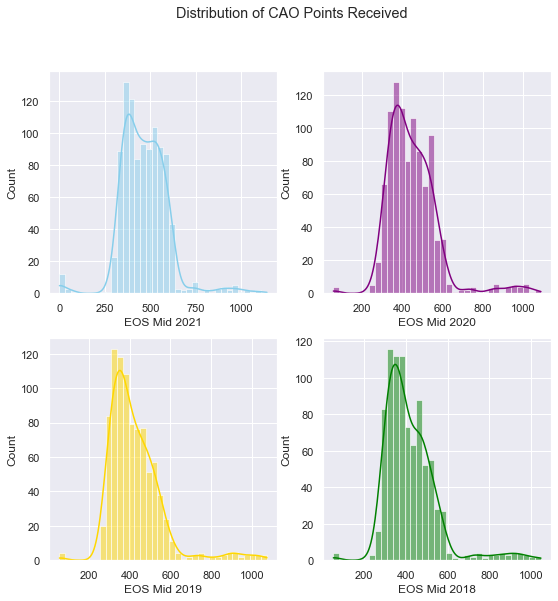

In [258]:
# Use the function to plot a 2x2 Histogram plot by year for Mid Points
hist_l8_mid = hist_by_year(allcourses_l8_mid)

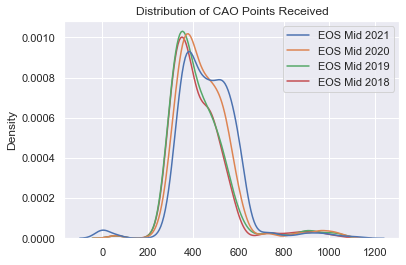

In [259]:
# View the KDE of the Mid l8 points values each year
sns.kdeplot(data=allcourses_l8_mid).set_title("Distribution of CAO Points Received")
plt.savefig('cao-analysis\level-8\kde-mid-l8.png')

The histogram of Mid points for all courses follows a similarly shaped distribution for each year. Overlapping the kernel density estimate curve of each year shows the similarity, while also showing how the curve has moved slightly more to the right each year, showing how the points of applicants are increasing each year.

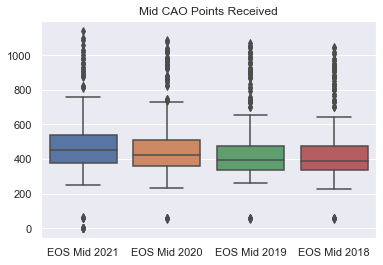

In [260]:
# Boxplot of level 8 Mid points
sns.boxplot(data=allcourses_l8_mid).set_title("Mid CAO Points Received")
plt.savefig(r'cao-analysis\level-8\box-mid-l8.png')

A boxplot also illustrates the trend of points increasing each year. Each year has a similar amount of courses that seaborn calculates as outliers, most of which are at the higher end. These are likely all courses that have additional requirements such as an audition or portfolio which increases the points requirement past the typical ceiling of 600 points. Since these are valid courses and are similar in number each year they probably shouldn't be considered outliers in the typical sense, which are values extreme enough to influence the analysis outcome in a manner that could lead to incorrect inferences[<sup>19</sup>](#f19)<a id='a19'></a>.

Since there are so many courses, it's not feasible to plot them all at once, but we can use a function that will return a barplot showing how both the EOS points and EOS Mid points change based on the year. To use the function, one needs to know the course code they wish to see plotted, and pass that code in as an argument of the function within inverted commas, and the dataframe that the course can be found in. It is recommended that this function is only used with the following dataframes: 
allcourses_l8_eos (For Level 8 courses)
allcourses_l76_eos (For Level 7 and 6 courses)
An image of the barplot will also be saved. An example of this can be seen below.

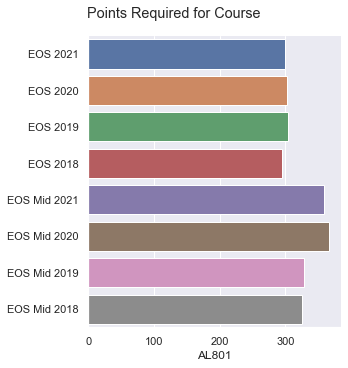

In [261]:
# Barplot of points for a course passed as an argument
course_bar('AL801', df=allcourses_l8_eos)

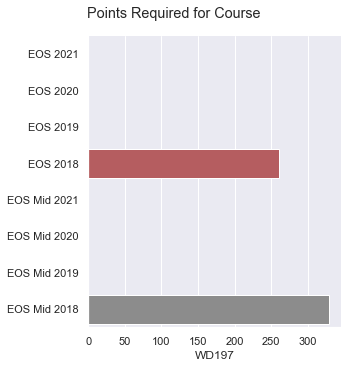

In [262]:
# Testing the function with a different course
course_bar('WD197', df=allcourses_l8_eos)

We can see from the course code 'WD197' shows that the course was only on offer in 2018, which is an example that shows that even though the number of level 8 courses has increased over the years, there are some level 8 courses that are no longer on offer. 

### Level 7 and 6 Analysis<a id='h18'></a>

The same strategy will be used with level 7 and 6 data, by first looking at the mid values from each year. 

In [263]:
# New df containing level 6 and 7 mid points columns
allcourses_l76_mid = pd.DataFrame(index=allcourses_l76_eos.index.copy())
allcourses_l76_mid = allcourses_l76_eos[["Course Title", "EOS Mid 2021", "EOS Mid 2020", 
                                   "EOS Mid 2019", "EOS Mid 2018"]]

In [264]:
# View the dataframe
allcourses_l76_mid

,Course Title,EOS Mid 2021,EOS Mid 2020,EOS Mid 2019,EOS Mid 2018
Course Code,,,,,
AL605,Music and Instrument Technology,319.0,306.0,NaN,NaN
AL630,Pharmacy Technician,409.0,379.0,366.0,388.0
AL631,Dental Nursing,400.0,388.0,379.0,348.0
AL632,Applied Science,454.0,434.0,372.0,444.0
AL650,Business,351.0,326.0,317.0,357.0
...,...,...,...,...,...
TL621,Hotel Operations,NaN,NaN,NaN,214.0
TL622,Travel and Tourism Studies,NaN,NaN,NaN,280.0
TL720,Travel and Tourism Management,NaN,NaN,NaN,359.0


In [265]:
# View the dataframe
allcourses_l76_mid.describe()

,EOS Mid 2021,EOS Mid 2020,EOS Mid 2019,EOS Mid 2018
count,417.000000,434.000000,453.000000,460.000000
mean,396.223022,377.048387,345.830022,340.893478
std,94.631830,75.252370,77.590483,91.262863
min,0.000000,192.000000,146.000000,92.000000
25%,357.000000,337.000000,300.000000,295.500000
50%,391.000000,368.000000,337.000000,330.000000
75%,431.000000,403.000000,377.000000,369.000000
max,900.000000,892.000000,873.000000,924.000000


While the number of level 8 courses have increased every year, the number of level 6 and 7 courses has decreased every year. There are 43 fewer level 6 and 7 courses in 2021 compared with 2018. The trend of increasing Mid points on average each year continues with the mean being around 55 points higher in 2021 than in 2018.

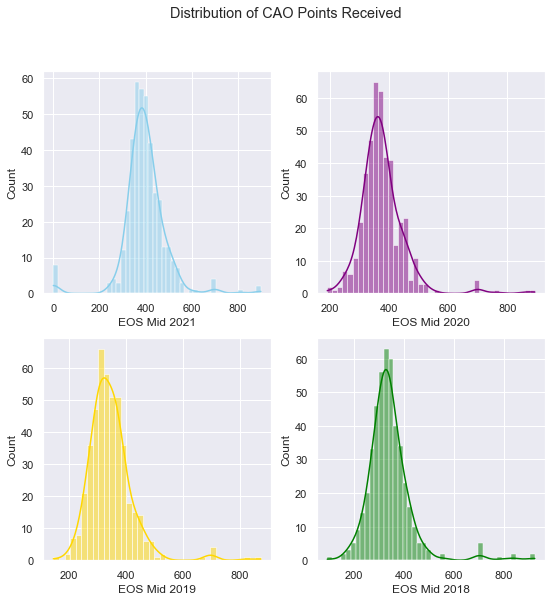

In [266]:
# Use the function to plot a 2x2 Histogram plot by year for Mid Points
hist_l76_mid = hist_by_year(allcourses_l76_mid)

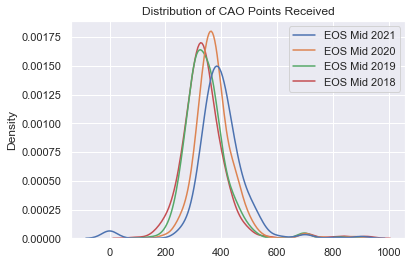

In [267]:
# View the KDE of the Mid l7 and 6 points values each year
sns.kdeplot(data=allcourses_l76_mid).set_title("Distribution of CAO Points Received")
plt.savefig('cao-analysis\level-7-and-6\kde-mid-l76.png')

The histograms and KDE curves show a similar pattern for level 7 and 6 courses as with level 8 courses. The density is moving right each year as the average Mid points for most courses increases each year.

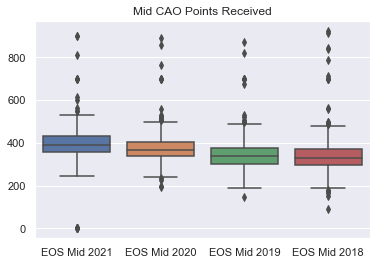

In [268]:
# Boxplot of level 7 and 6 Mid points
sns.boxplot(data=allcourses_l76_mid).set_title("Mid CAO Points Received")
plt.savefig(r'cao-analysis\level-7-and-6\box-mid-l76.png')

The boxplot again shows the mean points increasing over the years, while the number of outliers estimated by seaborn has decreased across the years, which is likely visible due to the decrease in the number of courses offered each year. As there are almost half the number of level 7 and 6 courses on offer as level 8 courses any changes of this kind is more noticeable when plotted.

We can reuse the function for creating a barplot based on the course code, but for it to work the default dataframe passed as an argument needs to be changed to specify the level 7 and 6 dataframe.

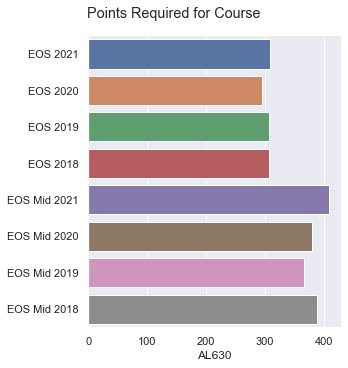

In [269]:
# Barplot of points for a course passed as an argument
course_bar('AL630', df=allcourses_l76_eos)

### Analysis - All Levels<a id='h19'></a>

We can look at whether there's been a change in the number of courses where everybody who applied received an offer across the years due to the CAO marking these courses with AQA.

In [270]:
# Create a dictionary with the counts from each year of courses marked AQA
aqa_count = {'AQA_2021': [df2021_xlsx_aqa['Course Code'].count()], 
             'AQA_2020': [df2020_aqa['Course Code'].count()], 
             'AQA_2019': [df2019_l8_aqa['Course Code'].count() + df2019_l76_aqa['Course Code'].count()],
             'AQA_2018': [df2018_l8_aqa['Course Code'].count() + df2018_l76_aqa['Course Code'].count()],
            }
# Create dataframe from the dictionary
aqa_count_df = pd.DataFrame(data=aqa_count)

In [271]:
# View AQA dataframe
aqa_count_df

,AQA_2021,AQA_2020,AQA_2019,AQA_2018
0,18,26,20,18


We can see that the number has mostly stayed stable, except for in 2020 when it jumped up to 26. We can also look at whether there's an increase in courses that have additional requirements such as an interview/audition/portfolio.

In [272]:
# Create a dictionary with the couunts from each year of courses marked as requiring a portfolio/audition/interview
portfolio_count = {'Portfolio_2021': [df2021_portfolio_xslx['Course Code'].count()], 
             'Portfolio_2020': [df2020_portfolio['Course Code'].count()], 
             'Portfolio_2019': [df2019_l8_portfolio['Course Code'].count() + df2019_l76_portfolio['Course Code'].count()],
             'Portfolio_2018': [df2018_l8_portfolio['Course Code'].count() + df2018_l76_portfolio['Course Code'].count()],
            }
# Create dataframe from the dictionary
portfolio_count_df = pd.DataFrame(data=portfolio_count)

In [273]:
# View Portfolio dataframe
portfolio_count_df

,Portfolio_2021,Portfolio_2020,Portfolio_2019,Portfolio_2018
0,119,127,109,98


Again, the count for 2020 is much higher than for other years. These values may be a reflection of the impact that the coronavirus pandemic had in 2020, which led to the cancellation of the Leaving Certificate exams and CAO points instead being estimated by teachers[<sup>20</sup>](#f20)<a id='a20'></a>. 

### Conclusion<a id='h20'></a>

The main takeaways appear to be that the trend is for the points required for courses is increasing year on year, that there is a move towards increasing the number of Level 8 courses at the expense of Level 7 and 6 courses, and that there are some anomalies in how places were awarded in 2020, possibly due to the Coronavirus pandemic. The groundwork has also been set for further analysis, such as with the EOS columns that include interpolated values, but were analysis done with these the fact that the interpolation might not be accurate and may skew findings should be kept in mind. 

-------------------

## References<a id='h21'></a>

**1**.<a id='f1'></a> CAO, 2022. About CAO. [online] Available at: <http://www.cao.ie/index.php?page=aboutCAO> [Accessed 02 January 2022].[↩](#a1)    
**2**.<a id='f2'></a> State Examination Commission, 2022. Description Of Certificate Examinations. [online] Available at: <https://www.examinations.ie/?l=en&mc=ca&sc=sb> [Accessed 02 January 2022].[↩](#a2)    
**3**.<a id='f3'></a> CAO, 2022. Points Required for Entry to 2021 Level 8 Courses. [online]. Available at: <http://www2.cao.ie/points/l8.php> [Accessed 02 January 2022].[↩](#a3)     
**4**.<a id='f4'></a> py4u.net, 2022. Why am I getting a UnicodeDecodeError in Python's JSON encoding? [online]. Available at: <https://www.py4u.net/discuss/154653> [Accessed 02 January 2022].[↩](#a4)     
**5**.<a id='f5'></a> w3Schools, 2022. Python File write() Method. [online] Available at: <https://www.w3schools.com/python/ref_file_write.asp > [Accessed 02 January 2022].[↩](#a5)      
**6**.<a id='f6'></a> CAO, 2022. Points Required for Entry to 2021 Level 7/6 Courses. [online]. Available at: <http://www2.cao.ie/points/l76.php> [Accessed 02 January 2022].[↩](#a6)      
**7**.<a id='f7'></a> CAO, 2022. Points Required for Entry to 2021 Courses. [online]. Available at: <http://www.cao.ie/index.php?page=points&p=2021> [Accessed 02 January 2022]. [↩](#a7)     
**8**.<a id='f8'></a> Pandas, 2022. pandas.read_excel. [online]. Available at: <https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html> [Accessed 02 January 2022]. [↩](#a8)     
**9**.<a id='f9'></a> Stackoverflow, 2020. Pandas cannot open an Excel (.xlsx) file. [online] Available at: <https://stackoverflow.com/questions/65250207/pandas-cannot-open-an-excel-xlsx-file> [Accessed 02 January 2022].[↩](#a9)   
**10**.<a id='f10'></a> CAO, 2022. Points Required for Entry to 2020 Courses. [online]. Available at: <http://www.cao.ie/index.php?page=points&p=2020> [Accessed 02 January 2022].[↩](#a10)     
**11**.<a id='f11'></a> CAO, 2022. Points Required for Entry to 2019 Courses. [online]. Available at: <http://www.cao.ie/index.php?page=points&p=2019> [Accessed 02 January 2022].[↩](#a11)    
**12**.<a id='f12'></a> Stackoverflow, 2021. How to extract multiples tables from one PDF file using Pandas and tabula-py. [online] Available at: <https://stackoverflow.com/questions/68408688/how-to-extract-multiples-tables-from-one-pdf-file-using-pandas-and-tabula-py> [Accessed 02 January 2022].[↩](#a12)     
**13**.<a id='f13'></a> tabula-py, 2022. tabula.io.read_pdf. [online]. Available at: https://tabula-py.readthedocs.io/en/latest/tabula.html#tabula.io.read_pdf [Accessed 02 January 2022]. [↩](#a13)      
**14**.<a id='f14'></a> Pandas, 2022. pandas.Series.str.match. [online]. Available at: < https://pandas.pydata.org/docs/reference/api/pandas.Series.str.match.html> [Accessed 02 January 2022].[↩](#a14)      
**15**.<a id='f15'></a> CAO, 2022. Points Required for Entry to 2018 Courses. [online]. Available at: <http://www.cao.ie/index.php?page=points&p=2018> [Accessed 02 January 2022].[↩](#a15)      
**16**.<a id='f16'></a> McLoughlin, Ian, 2021. CAO Points Analysis. [online]. Available at: https://github.com/ianmcloughlin/cao-points/blob/main/cao-points-analysis.ipynb [Accessed 02 January 2022].[↩](#a16)      
**17**.<a id='f17'></a> Pandas, 2022. pandas.DataFrame.drop_duplicates. [online]. Available at: <https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html> [Accessed 02 January 2022].[↩](#a17)     
**18**.<a id='f18'></a> Brownlee, J., 2017. How to Handle Missing Data with Python. [online]. Available at: https://machinelearningmastery.com/handle-missing-data-python/ [Accessed 02 January 2022].[↩](#a18)     
**19**.<a id='f19'></a> Sequitin, K., 2021. What Is an Outlier? [online]. Available at: https://careerfoundry.com/en/blog/data-analytics/what-is-an-outlier/ [Accessed 02 January 2022].[↩](#a19)     
**20**.<a id='f20'></a> RTE, 2020. 5 things we learned about this year's Leaving Cert. [online]. Available at: <https://www.rte.ie/news/education/2020/0508/1137313-leaving-cert-q-a/ [Accessed 02 January 2022].[↩](#a20)
